In [1]:
import pandas as pd
import numpy as np
import os
import re
import csv
import json
from scipy.spatial.distance import euclidean
from unidecode import unidecode
from tslearn.metrics import dtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

/usr/local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 🧹 CSV cleaning

begin with `ids.csv`, `/pitch`, `/words` populated from the spreadsheet.

1. make sure filenames in `/pitch` and `/words` are valid ids
2. make sure all csvs are formatted with the correct columns
3. in `/words`, group words into phrases
4. in `/pitch`, transpose notes to the standard key
5. write cleaned data to `/pitch-transposed` and `/words-phrased`

In [13]:
def clean():
    folders = ['pitch', 'words']

    missing_ids = check_ids()
    
    print('Checking that ids.csv and /pitches /words match')
    if len(missing_ids) > 0:
        print(f"{len(missing_ids)} missing files.")
        print(missing_ids)
#         return
    else:
        print('All good ✅')
    
    invalid_csvs = check_csvs(folders)
    
    print('Checking valid csv format')
    if (len(invalid_csvs) > 0):
        print(f"{len(invalid_csvs)} invalid csvs.")
        print(invalid_csvs)
        return
    else:
        print('All good ✅')
        
    with open('ids.csv', 'r') as file:
        reader = csv.reader(file)
        row_count = sum(1 for row in reader)
    print(f"{row_count - 1} national anthems ready to analyze.")
    
    print('Cleaning /words - phrasing')
    clean_words()
    print('Done ✅')
    
    print('Cleaning /pitch - transposing')
    clean_pitch()
    print('Done ✅')

clean()

Checking that ids.csv and /pitches /words match
All good ✅
Checking valid csv format
All good ✅
137 national anthems ready to analyze.
Cleaning /words - phrasing
Done ✅
Cleaning /pitch - transposing
1: patrick-stump_world-series_2016_pitch.csv
2: gretchen-wilson_nba-allstar-game_2010_pitch.csv
3: kelly-clarkson_indy-500_2019_pitch.csv
4: carly-pearce_world-series_2021_pitch.csv
5: trisha-yearwood_world-series_2014_pitch.csv
6: kelly-clarkson_world-series_2010_pitch.csv
7: jordan-smith_nfl-regular-season_2023_pitch.csv
8: luke-bryan_super-bowl_2017_pitch.csv
9: fergie_nba-allstar-game_2018_pitch.csv
10: alicia-keys_super-bowl_2013_pitch.csv
11: hunter-hayes_world-series_2016_pitch.csv
12: taylor-swift_world-series_2008_pitch.csv
13: jordin-sparks_super-bowl_2008_pitch.csv
14: demi-lovato_world-series_2015_pitch.csv
15: melissa-etheridge_world-series_2002_pitch.csv
16: juanita-booker_inauguration_1981_pitch.csv
17: cheryl-ladd_super-bowl_1980_pitch.csv
18: diana-ross_super-bowl_1982_pitc

In [3]:
def check_ids():
    missing_ids = []
    existing_ids = set()

    with open('ids.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_value = row['id']
            existing_ids.add(id_value)
            words_file = f'words/{id_value}_words.csv'
            pitch_file = f'pitch/{id_value}_pitch.csv'

            if not os.path.isfile(words_file):
                missing_ids.append(id_value + '(words file)')
            if not os.path.isfile(pitch_file):
                missing_ids.append(id_value + '(pitch file)')

    for folder in ['words', 'pitch']:
        for file in os.listdir(folder):
            if file.endswith('.csv'):
                file_id = '_'.join(file.rsplit('_', 1)[0:-1])
                if file_id not in existing_ids:
                    missing_ids.append(file_id + ' missing in ids.csv')

    return missing_ids

In [4]:
def check_csv_columns(file_path, expected_columns):
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) != len(expected_columns):
                return False
    return True

def check_csvs(folders):
    invalid_csvs = []
    for folder in folders:
        expected_columns = ["timestamp", "frequency"] if folder == 'pitch' else ["timestamp", "frequency", "duration", "word"]

        for filename in os.listdir(folder):
            if not filename.endswith('.csv'): 
                continue
            
            valid = check_csv_columns(os.path.join(folder, filename), expected_columns)
            if not valid:
                invalid_csvs.append(os.path.join(folder, filename))

    return invalid_csvs   

In [11]:
def clean_words():
    output_folder = 'words-phrased'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ids = pd.read_csv('ids.csv')
    for id in ids['id']:
        filename = f'words/{id}_words.csv'
        if os.path.exists(filename):
            words = pd.read_csv(filename)          
            words_cleaned = add_phrases(words)
            words_cleaned.to_csv(f'{output_folder}/{id}.csv', index=False)
        
phrases = ['o-say-can-you-see', 'by-the-dawns-early-light', 'what-so-proudly-we-hailed', 'at-the-twilights-last-gleaming', 'whose-broad-stripes-and-bright-stars', 'through-the-perilous-fight', 'oer-the-ramparts-we-watched', 'were-so-gallantly-streaming', 'and-the-rockets-red-glare', 'the-bombs-bursting-in-air', 'gave-proof-through-the-night', 'that-our-flag-was-still-there', 'o-say-does-that-star-spangled', 'banner-yet-wave', 'oer-the-land-of-the-free', 'and-the-home-of-the-brave']
        
def add_phrases(words):
    words['phrase'] = None
    
    phrase_idx = 0
    word_idx = 0

    for i, row in words.iterrows():
        current_phrase = phrases[phrase_idx]
        if row['word'] not in current_phrase:
            phrase_idx += 1
            
        words.at[i, 'phrase'] = phrases[phrase_idx]

    return words

In [6]:
standard_key = 'C'

def clean_pitch():
    output_folder = 'pitch-transposed'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    current_file_number = 0
    for filename in os.listdir('pitch'):
        if not filename.endswith('csv'): continue
            
        current_file_number += 1
        print(f"{current_file_number}: {filename}")
        
            
        id_value = filename.replace('_pitch.csv', '')
        id_df = pd.read_csv('ids.csv')
        row = id_df[id_df['id'] == id_value]
        steps_from_C = row['steps_from_C'].iloc[0]
        
        pitch = pd.DataFrame(pd.read_csv('pitch/' + filename))
        
        if steps_from_C == 0:
            pitch_cleaned = pitch
        else:
            pitch_cleaned = normalize_pitch(pitch, steps_from_C)
        
        pitch_cleaned.to_csv(output_folder + '/' + filename, index=False)

def transpose(original_hz, steps_from_C):
    new_frequency = original_hz * (2 ** ((steps_from_C * -1) / 12))
    return new_frequency

def normalize_pitch(pitch_data, steps_from_C):
    normalized = []
    for index, row in pitch_data.iterrows():
        new_row = {col: row[col] for col in pitch_data.columns}
        new_row['frequency'] = transpose(row['frequency'], steps_from_C)
        normalized.append(new_row)
    return pd.DataFrame(normalized)

# 📈 Plotting pitch data

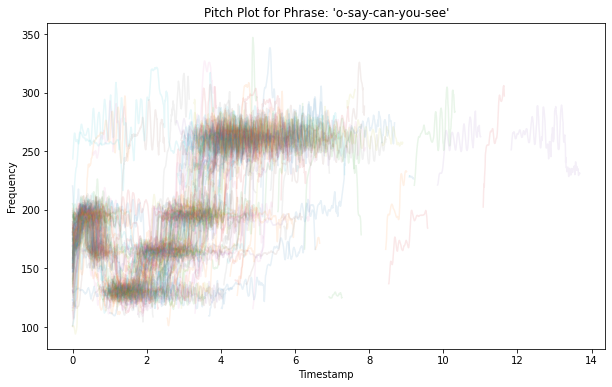

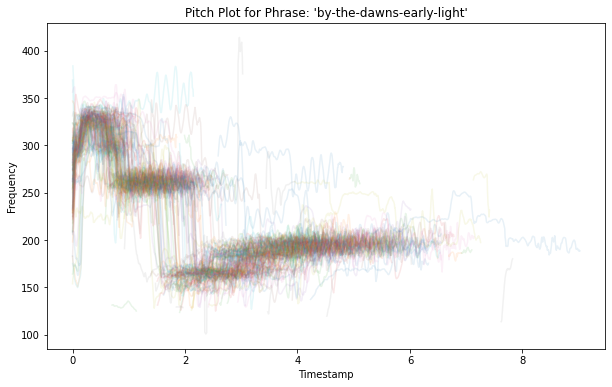

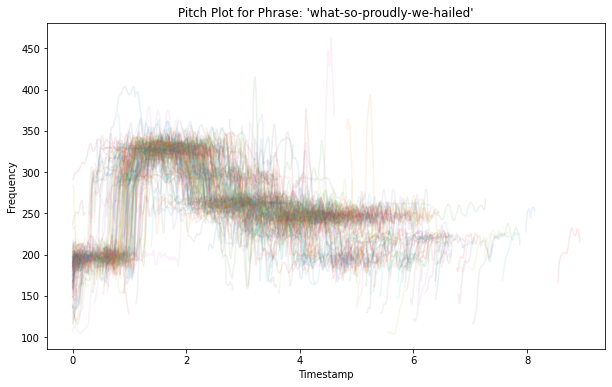

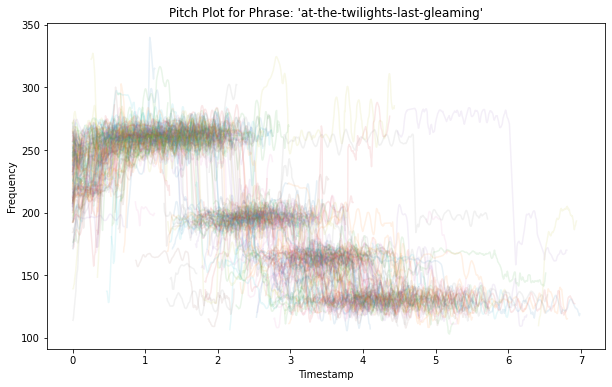

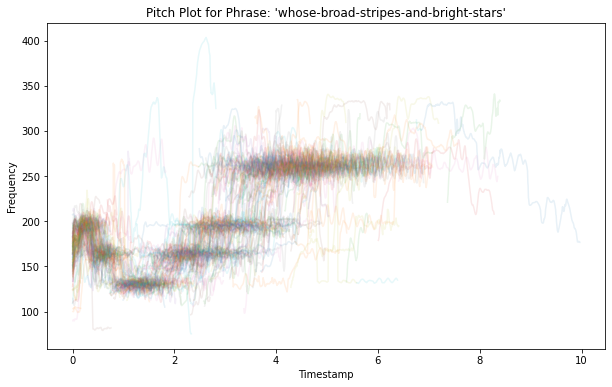

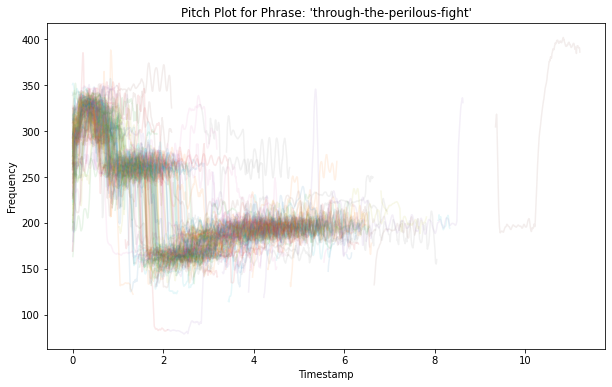

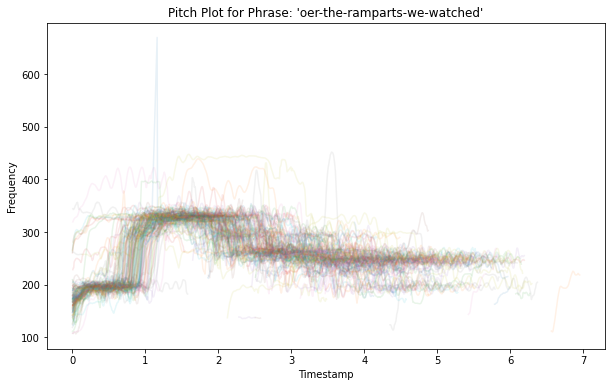

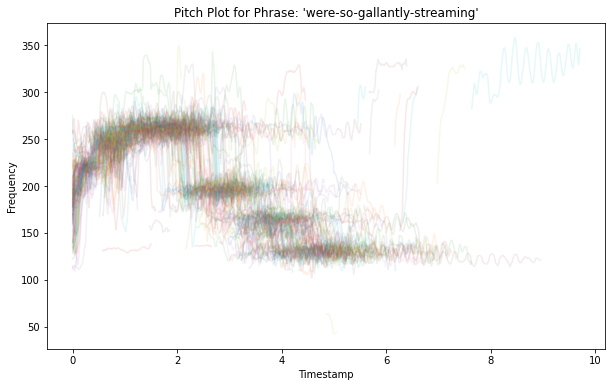

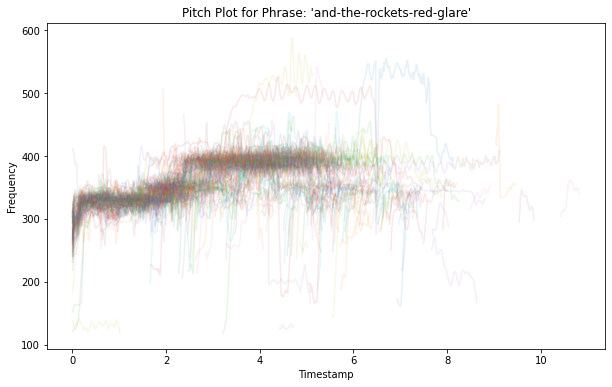

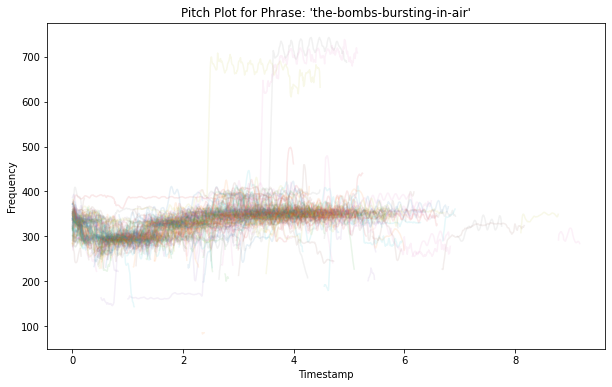

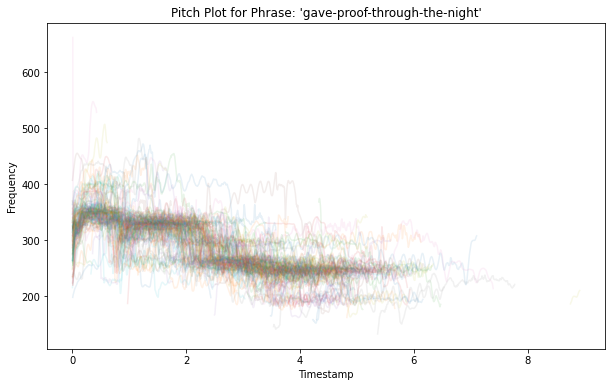

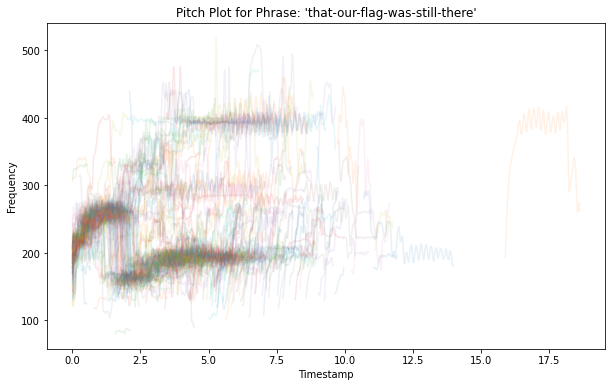

In [ ]:
phrases = ['o-say-can-you-see', 'by-the-dawns-early-light', 'what-so-proudly-we-hailed', 'at-the-twilights-last-gleaming', 'whose-broad-stripes-and-bright-stars', 'through-the-perilous-fight', 'oer-the-ramparts-we-watched', 'were-so-gallantly-streaming', 'and-the-rockets-red-glare', 'the-bombs-bursting-in-air', 'gave-proof-through-the-night', 'that-our-flag-was-still-there', 'o-say-does-that-star-spangled', 'banner-yet-wave', 'oer-the-land-of-the-free', 'and-the-home-of-the-brave']

def plot_pitches_by_phrase(words_path, pitch_path):
    ids = pd.read_csv('ids.csv')['id']

    for phrase in phrases:        
        plt.figure(figsize=(10, 6))
        plt.title(f"Pitch Plot for Phrase: '{phrase}'")
        plt.xlabel('Timestamp')
        plt.ylabel('Frequency')
        
        # Initialize a list to store pitch data for each id
        phrase_pitches = []

        for id in ids:
            # Load the words-phrased data
            words_df = pd.read_csv(f"{words_path}/{id}.csv")

            # Find start and end timestamps for the phrase
            phrase_data = words_df[words_df['phrase'] == phrase]
            if not phrase_data.empty:
                phrase_start_timestamp = phrase_data.iloc[0]['timestamp']
                phrase_end_timestamp = phrase_data.iloc[-1]['timestamp'] + phrase_data.iloc[-1]['duration']
                
                # Load pitch data and filter by timestamps
                pitch_df = pd.read_csv(f"{pitch_path}/{id}_pitch.csv")
                pitch_df = pitch_df[(pitch_df['timestamp'] >= phrase_start_timestamp) & (pitch_df['timestamp'] <= phrase_end_timestamp)]

                # Adjust timestamps so each curve starts at 0
                pitch_df['adjusted_timestamp'] = pitch_df['timestamp'] - phrase_start_timestamp
                
                # Add the pitch data to the list
                phrase_pitches.append({'id': id, 'pitch': pitch_df.to_dict(orient='records')})

                # Split the dataframe into segments where frequency is not 0
                segments = pitch_df[pitch_df['frequency'] > 0].copy()
                segments['gap'] = (segments['adjusted_timestamp'].diff() > 0.1) | (segments['frequency'].diff() == 0)
                for _, segment in segments.groupby((segments['gap'].cumsum())):
                    plt.plot(segment['adjusted_timestamp'], segment['frequency'], alpha=0.1)
        
        plt.show()
        
        # Save the pitch data for the phrase as a JSON file
        with open(f"phrases/{phrase}.json", 'w') as f:
            json.dump(phrase_pitches, f, indent=4)

plot_pitches_by_phrase('words-phrased', 'pitch-transposed')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


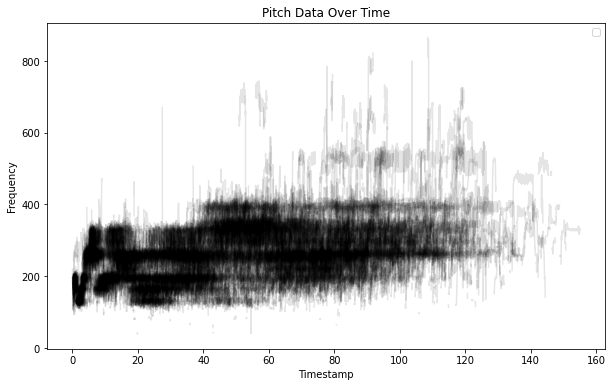

In [35]:
def plot_pitches(exclude):
    plt.figure(figsize=(10, 6))

    for filename in os.listdir('pitch-transposed'):
        if filename.endswith('.csv') and filename not in exclude:
            file_path = os.path.join('pitch-transposed', filename)

            # Read the CSV file
            data = pd.read_csv(file_path)

            # Process the data to create disconnected segments
            # Group the data by consecutive non-zero frequency values
            data['group'] = (data['frequency'] == 0).cumsum()
            grouped = data[data['frequency'] != 0].groupby('group')

            # Plot each segment
            for _, segment in grouped:
                plt.plot(segment['timestamp'], segment['frequency'], color='black', alpha=0.1)

    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.title('Pitch Data Over Time')
    plt.legend()
    plt.show()

exclude = []
plot_pitches(exclude)

In [33]:
def flag_high():
    for filename in os.listdir('pitch-transposed'):
        if not filename.endswith('.csv'): 
            continue

        file_path = os.path.join('pitch-transposed', filename)
        with open(file_path, newline='') as csvfile:
            reader = csv.DictReader(csvfile)

            for row in reader:
                try:
                    frequency = float(row['frequency'])
                    if frequency > 1000:
                        print(filename)
                        print(frequency)
                        break  # Break after the first occurrence in a file
                except ValueError:
                    continue  # Skip rows where frequency cannot be converted to float
    print('done')
flag_high()

done


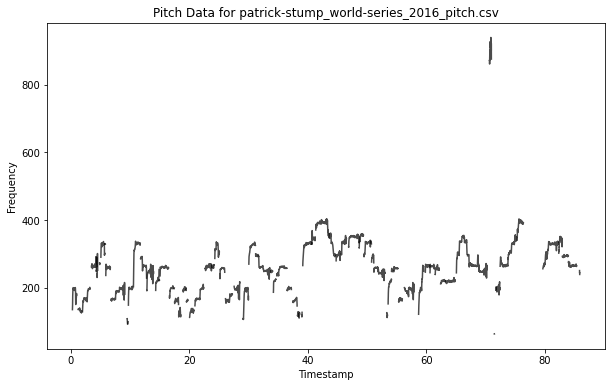

File 1: Flag file patrick-stump_world-series_2016_pitch.csv? (y/n): y


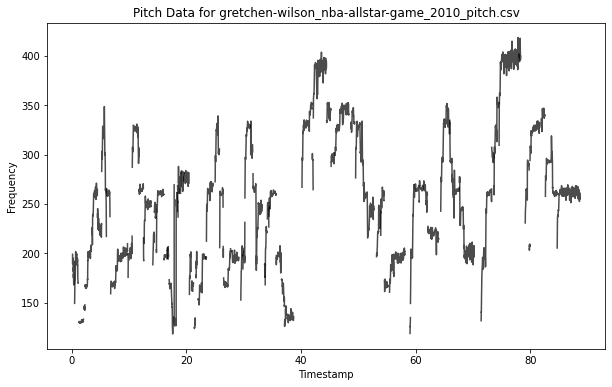

File 2: Flag file gretchen-wilson_nba-allstar-game_2010_pitch.csv? (y/n): n


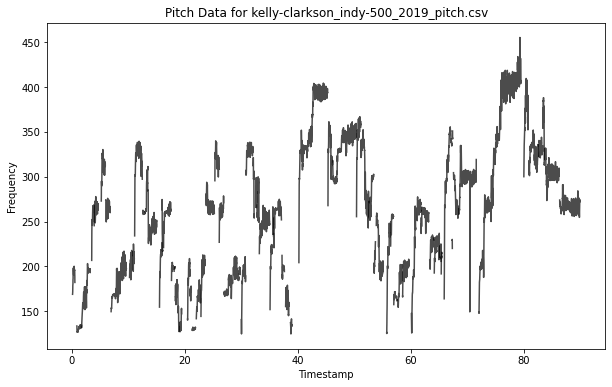

File 3: Flag file kelly-clarkson_indy-500_2019_pitch.csv? (y/n): n


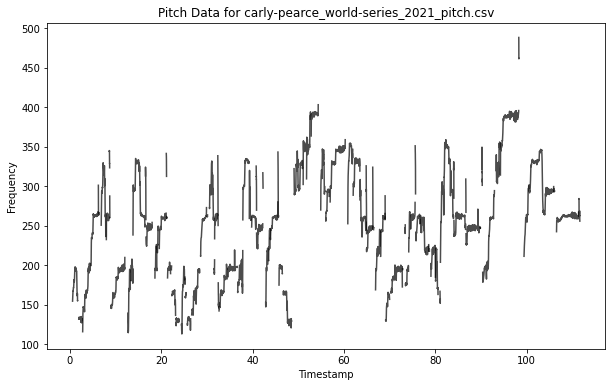

File 4: Flag file carly-pearce_world-series_2021_pitch.csv? (y/n): y


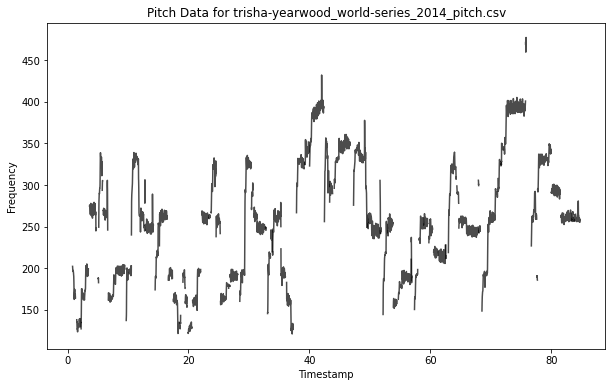

File 5: Flag file trisha-yearwood_world-series_2014_pitch.csv? (y/n): y


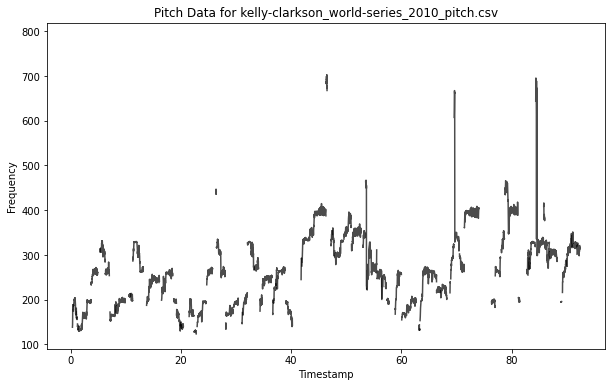

File 6: Flag file kelly-clarkson_world-series_2010_pitch.csv? (y/n): y


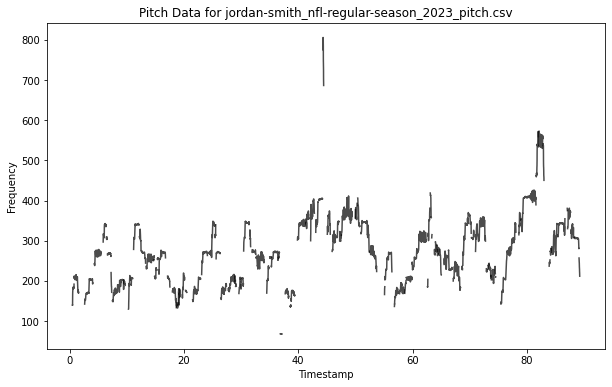

File 7: Flag file jordan-smith_nfl-regular-season_2023_pitch.csv? (y/n): y


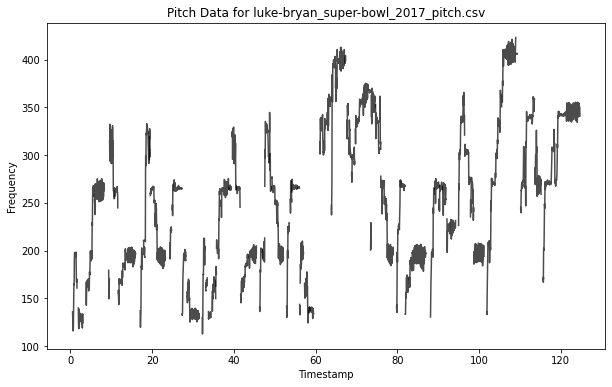

File 8: Flag file luke-bryan_super-bowl_2017_pitch.csv? (y/n): n


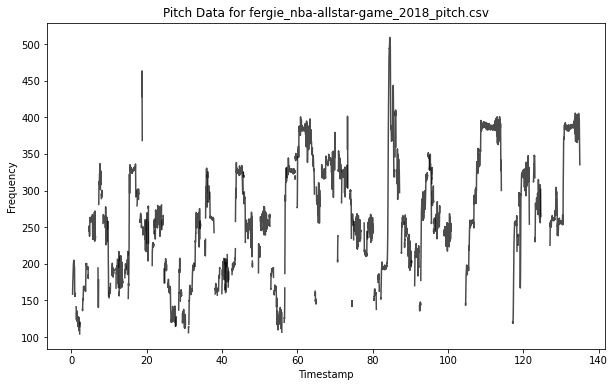

File 9: Flag file fergie_nba-allstar-game_2018_pitch.csv? (y/n): y


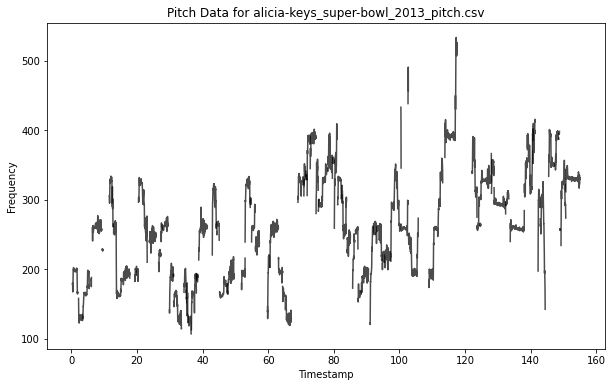

File 10: Flag file alicia-keys_super-bowl_2013_pitch.csv? (y/n): y


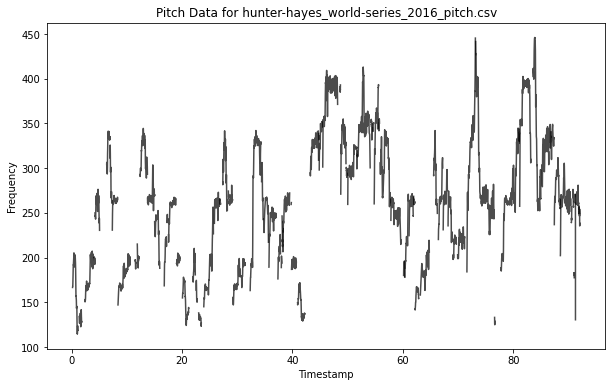

File 11: Flag file hunter-hayes_world-series_2016_pitch.csv? (y/n): n


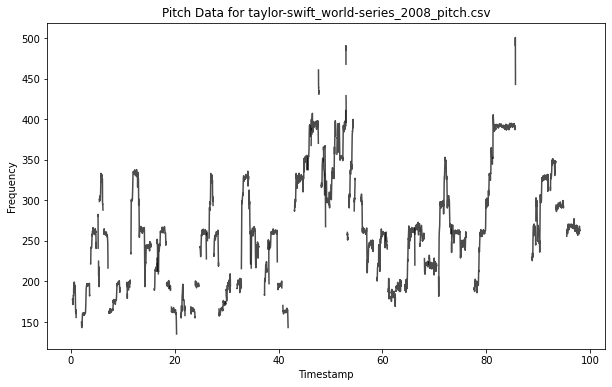

File 12: Flag file taylor-swift_world-series_2008_pitch.csv? (y/n): y


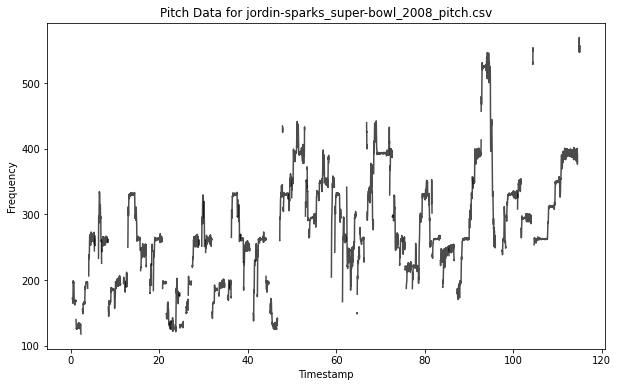

File 13: Flag file jordin-sparks_super-bowl_2008_pitch.csv? (y/n): y


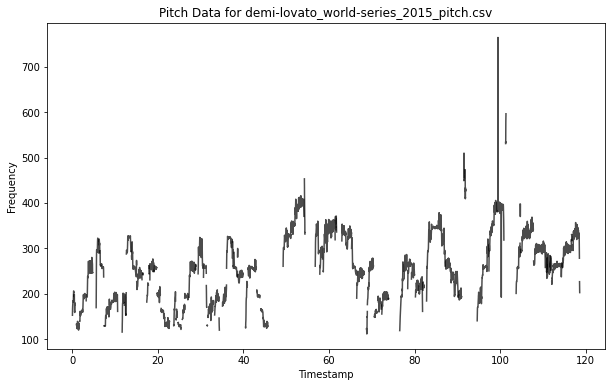

File 14: Flag file demi-lovato_world-series_2015_pitch.csv? (y/n): y


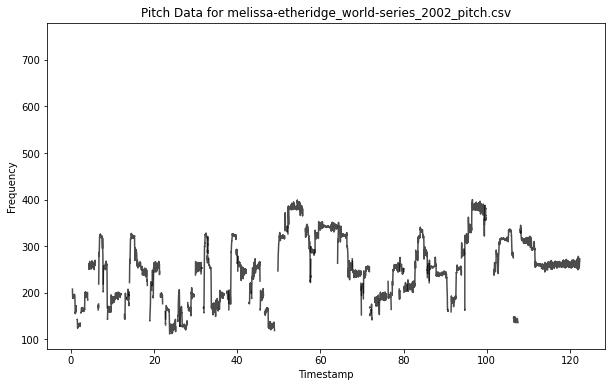

File 15: Flag file melissa-etheridge_world-series_2002_pitch.csv? (y/n): y


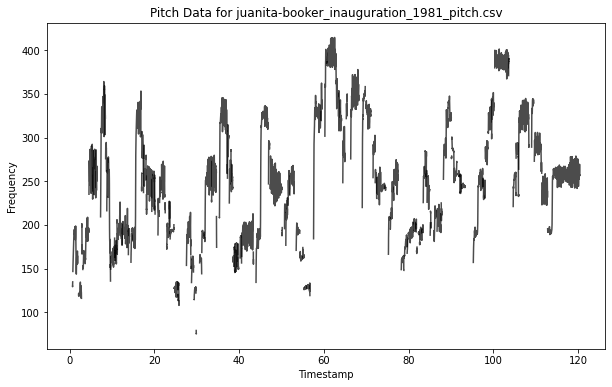

File 16: Flag file juanita-booker_inauguration_1981_pitch.csv? (y/n): n


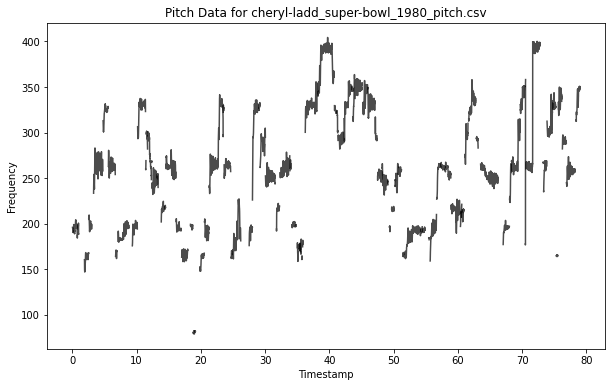

File 17: Flag file cheryl-ladd_super-bowl_1980_pitch.csv? (y/n): y


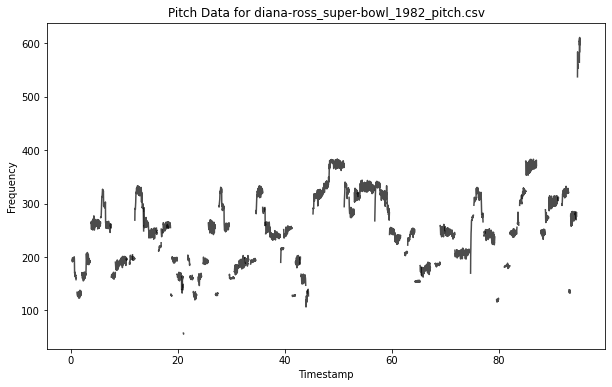

File 18: Flag file diana-ross_super-bowl_1982_pitch.csv? (y/n): y


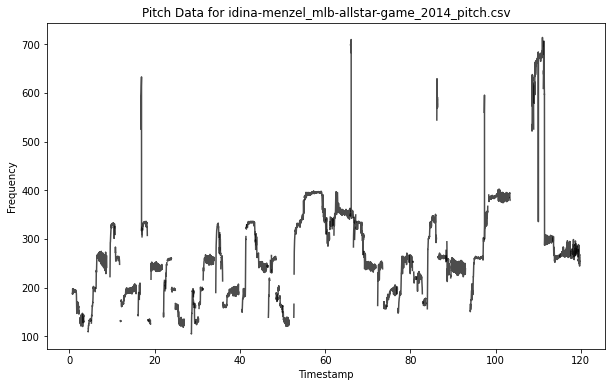

File 19: Flag file idina-menzel_mlb-allstar-game_2014_pitch.csv? (y/n): y


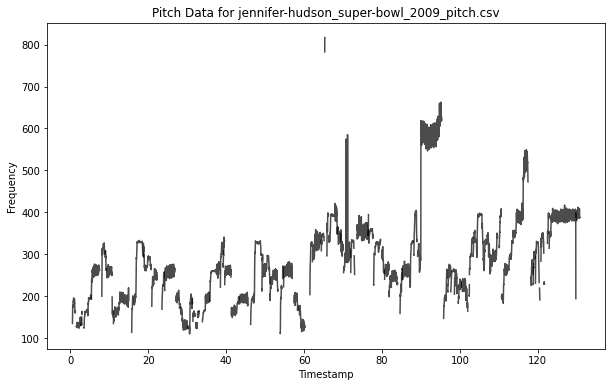

File 20: Flag file jennifer-hudson_super-bowl_2009_pitch.csv? (y/n): y


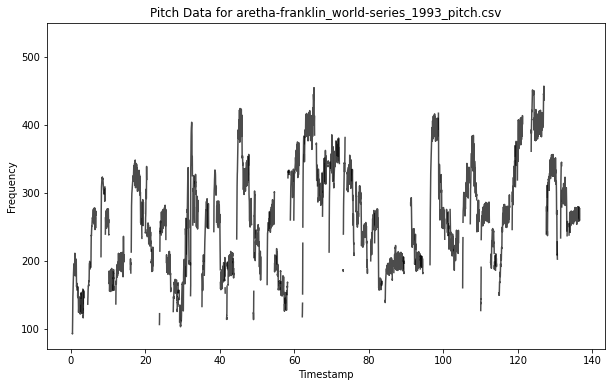

File 21: Flag file aretha-franklin_world-series_1993_pitch.csv? (y/n): n


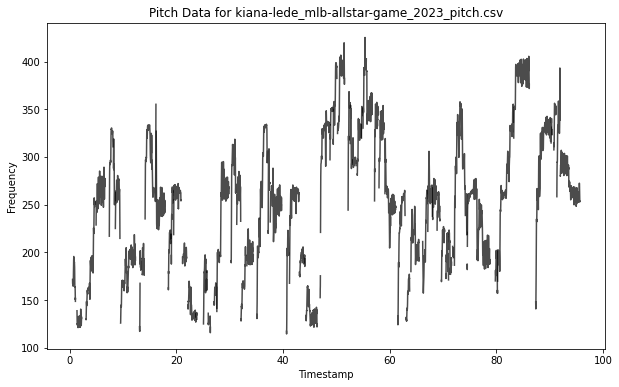

File 22: Flag file kiana-lede_mlb-allstar-game_2023_pitch.csv? (y/n): n


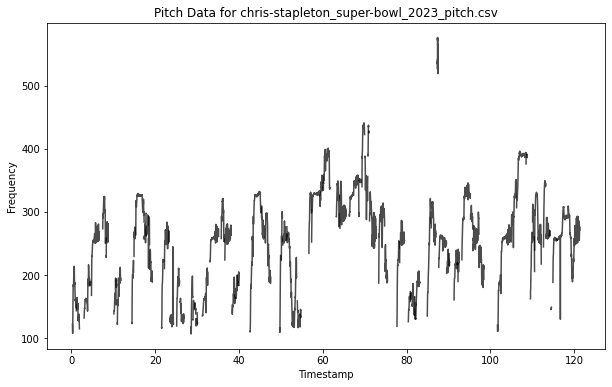

File 23: Flag file chris-stapleton_super-bowl_2023_pitch.csv? (y/n): y


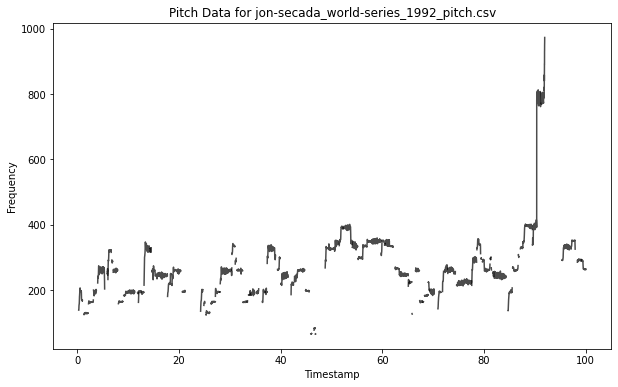

File 24: Flag file jon-secada_world-series_1992_pitch.csv? (y/n): y


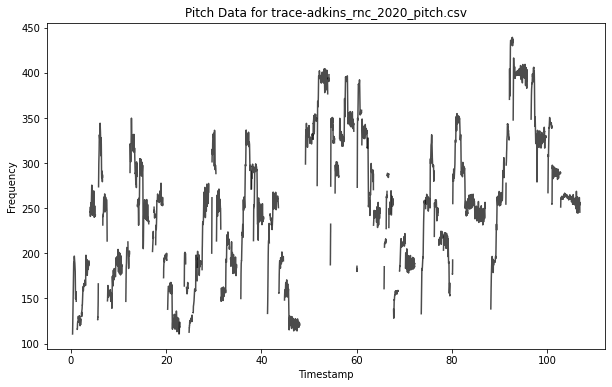

File 25: Flag file trace-adkins_rnc_2020_pitch.csv? (y/n): n


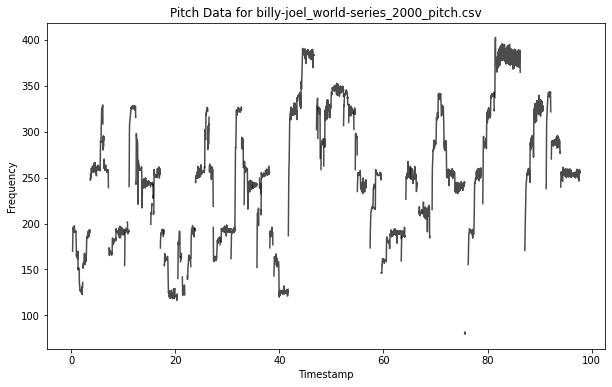

File 26: Flag file billy-joel_world-series_2000_pitch.csv? (y/n): n


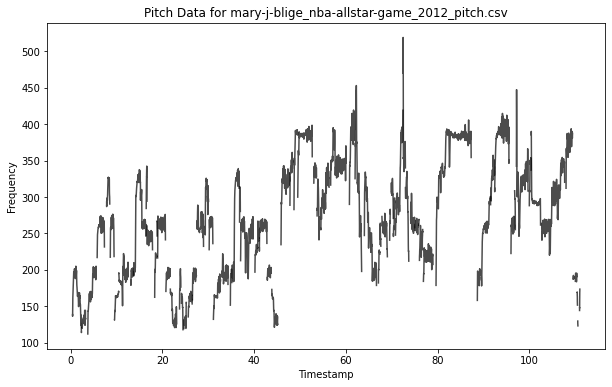

File 27: Flag file mary-j-blige_nba-allstar-game_2012_pitch.csv? (y/n): n


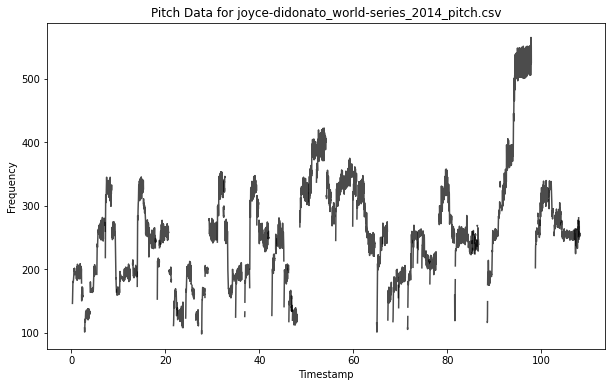

File 28: Flag file joyce-didonato_world-series_2014_pitch.csv? (y/n): n


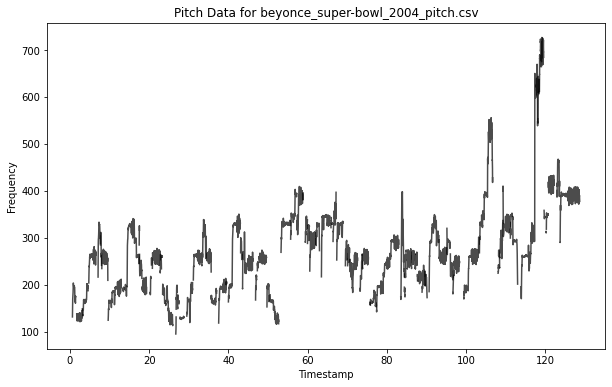

File 29: Flag file beyonce_super-bowl_2004_pitch.csv? (y/n): n


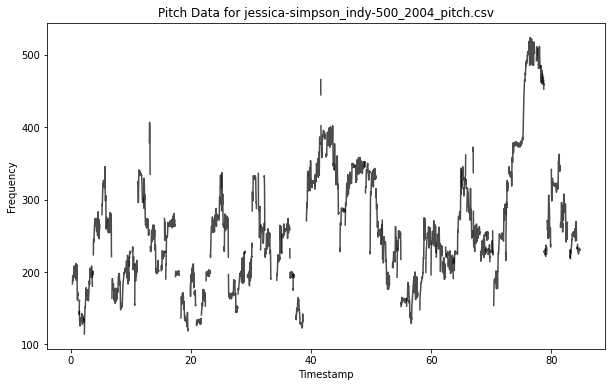

File 30: Flag file jessica-simpson_indy-500_2004_pitch.csv? (y/n): y


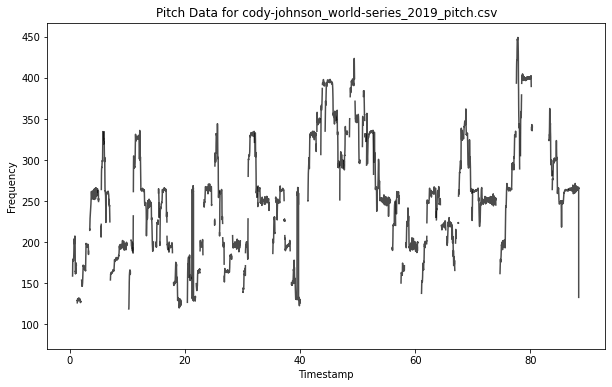

File 31: Flag file cody-johnson_world-series_2019_pitch.csv? (y/n): n


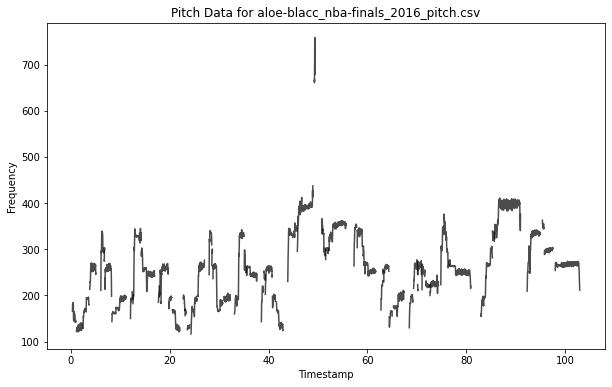

File 32: Flag file aloe-blacc_nba-finals_2016_pitch.csv? (y/n): y


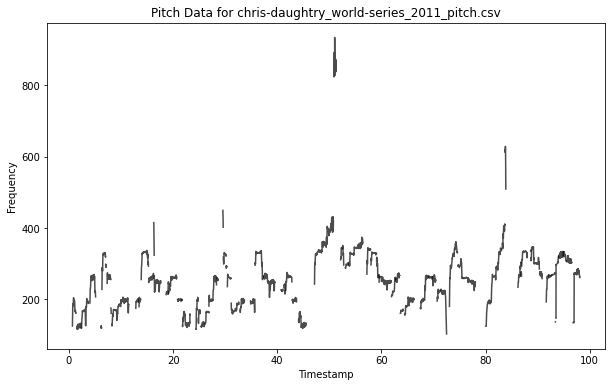

File 33: Flag file chris-daughtry_world-series_2011_pitch.csv? (y/n): y


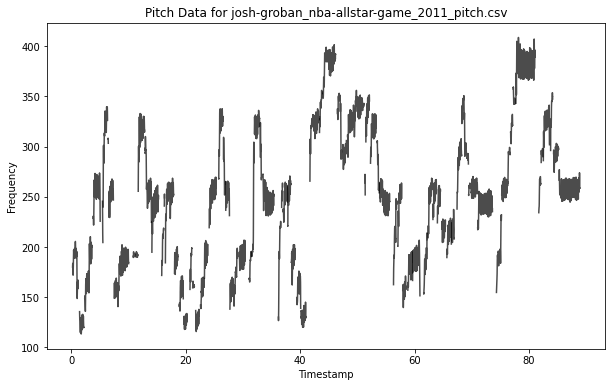

File 34: Flag file josh-groban_nba-allstar-game_2011_pitch.csv? (y/n): n


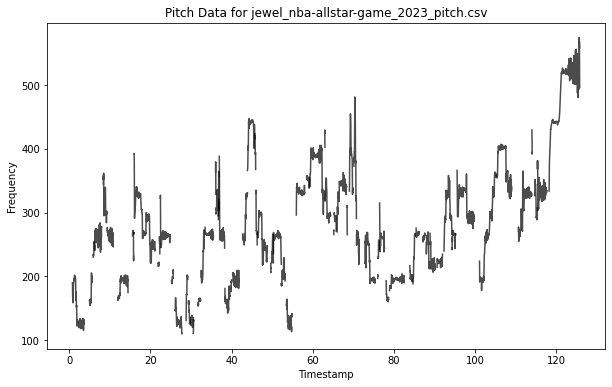

File 35: Flag file jewel_nba-allstar-game_2023_pitch.csv? (y/n): n


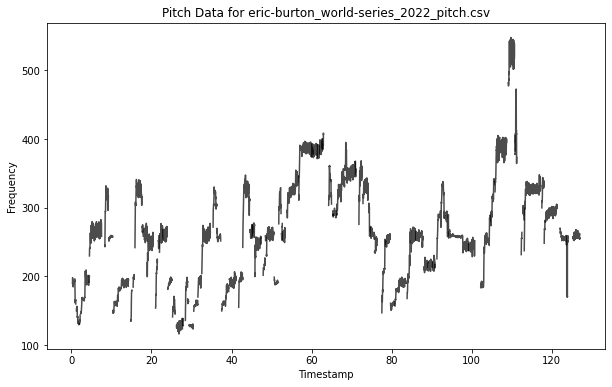

File 36: Flag file eric-burton_world-series_2022_pitch.csv? (y/n): n


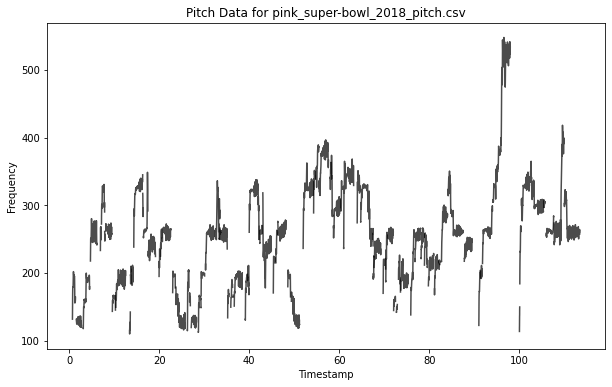

File 37: Flag file pink_super-bowl_2018_pitch.csv? (y/n): y


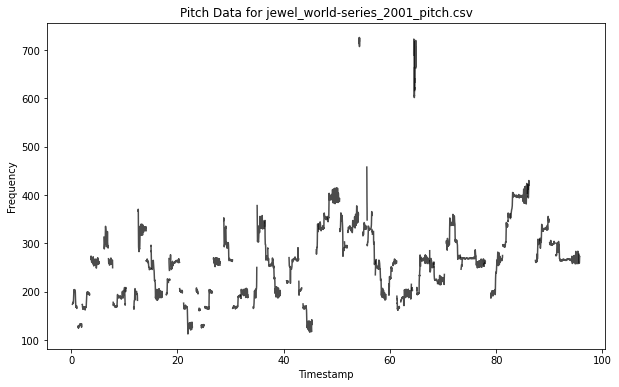

File 38: Flag file jewel_world-series_2001_pitch.csv? (y/n): y


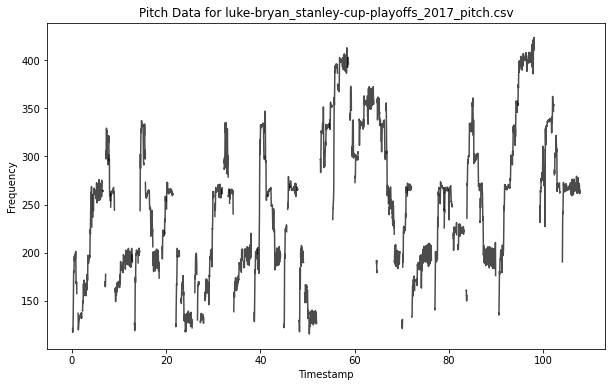

File 39: Flag file luke-bryan_stanley-cup-playoffs_2017_pitch.csv? (y/n): y


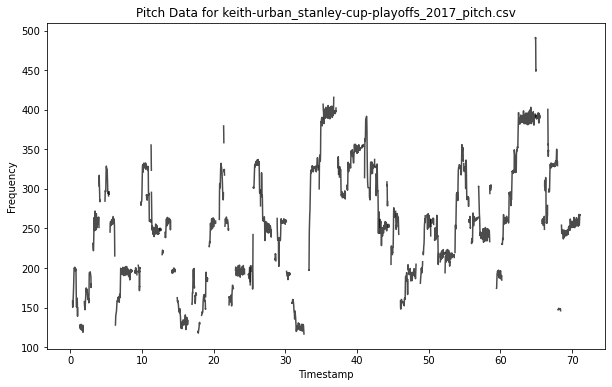

File 40: Flag file keith-urban_stanley-cup-playoffs_2017_pitch.csv? (y/n): y


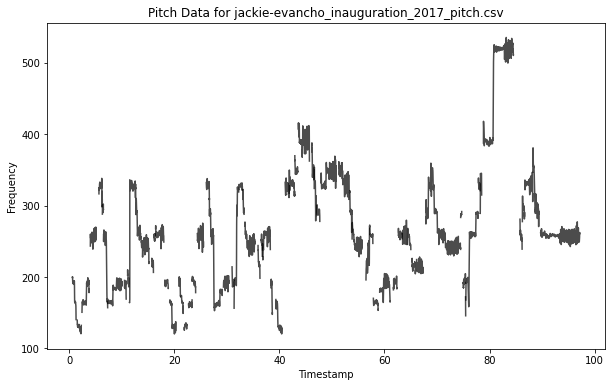

File 41: Flag file jackie-evancho_inauguration_2017_pitch.csv? (y/n): n


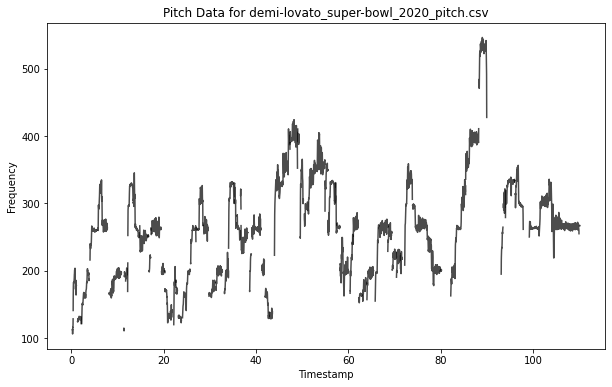

File 42: Flag file demi-lovato_super-bowl_2020_pitch.csv? (y/n): n


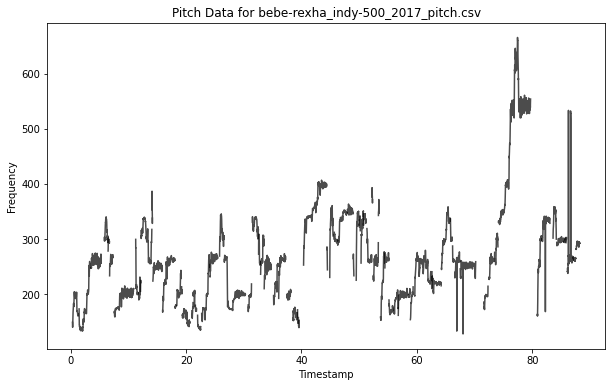

File 43: Flag file bebe-rexha_indy-500_2017_pitch.csv? (y/n): y


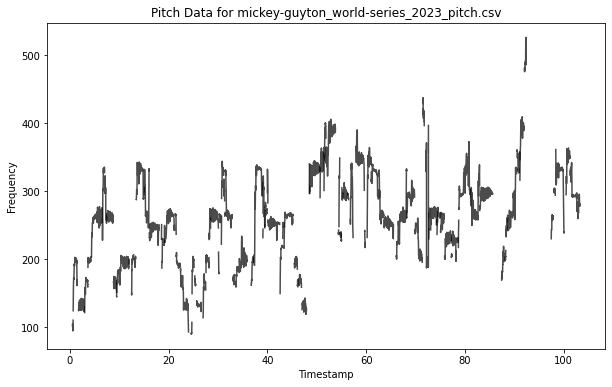

File 44: Flag file mickey-guyton_world-series_2023_pitch.csv? (y/n): y


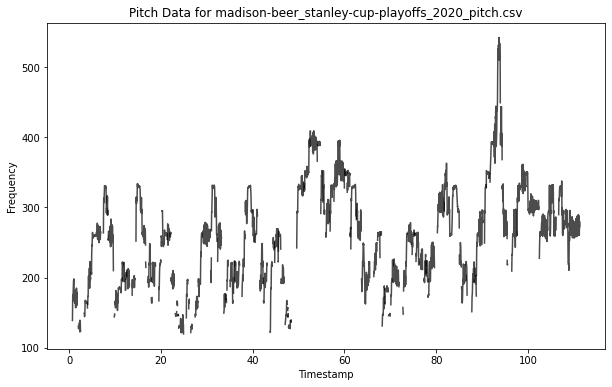

File 45: Flag file madison-beer_stanley-cup-playoffs_2020_pitch.csv? (y/n): n


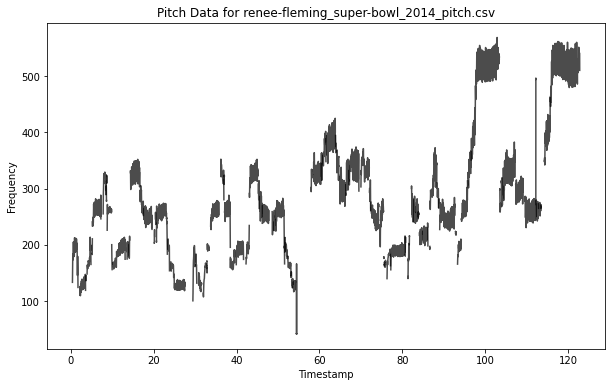

File 46: Flag file renee-fleming_super-bowl_2014_pitch.csv? (y/n): n


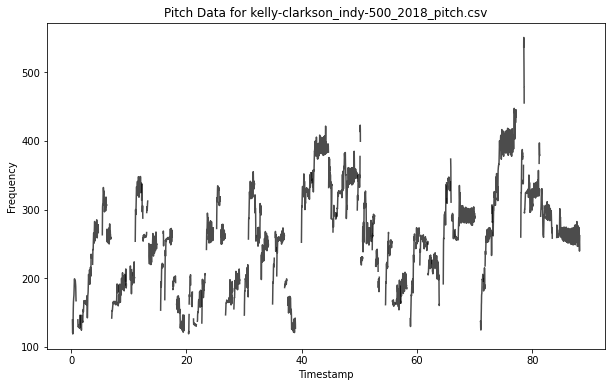

File 47: Flag file kelly-clarkson_indy-500_2018_pitch.csv? (y/n): y


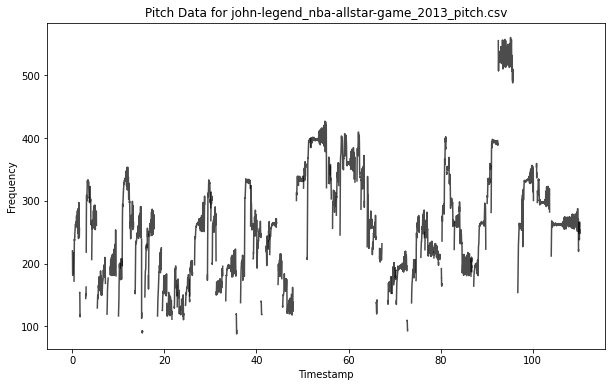

File 48: Flag file john-legend_nba-allstar-game_2013_pitch.csv? (y/n): y


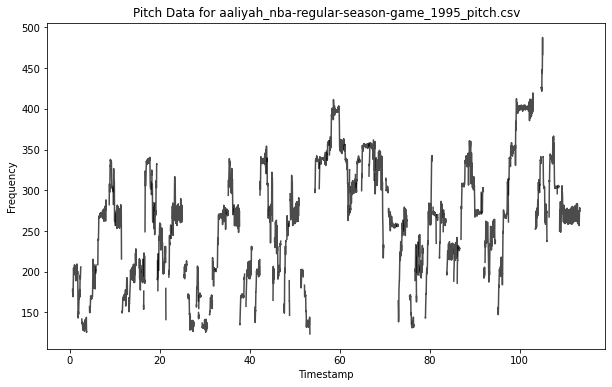

File 49: Flag file aaliyah_nba-regular-season-game_1995_pitch.csv? (y/n): y


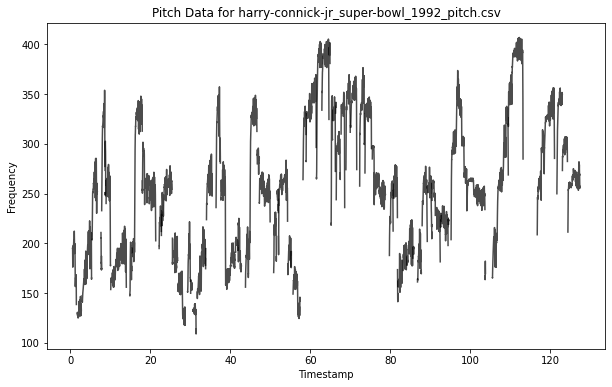

File 50: Flag file harry-connick-jr_super-bowl_1992_pitch.csv? (y/n): n


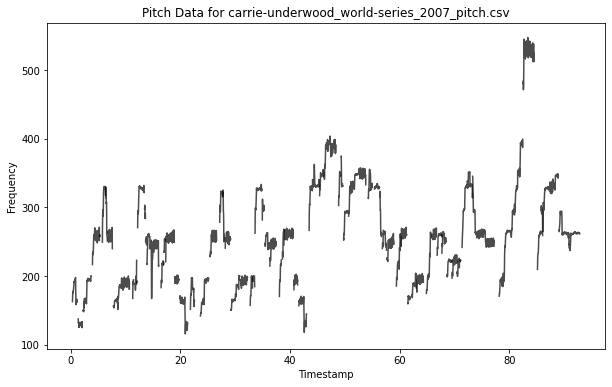

File 51: Flag file carrie-underwood_world-series_2007_pitch.csv? (y/n): y


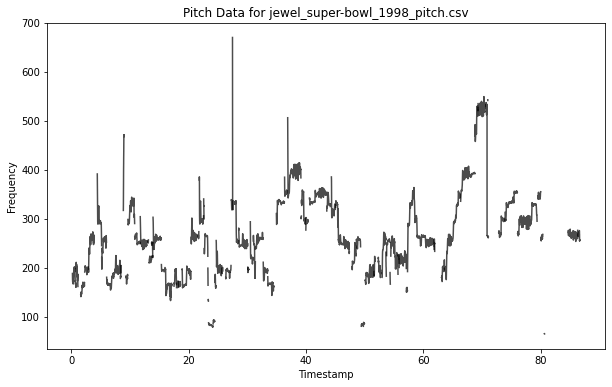

File 52: Flag file jewel_super-bowl_1998_pitch.csv? (y/n): n


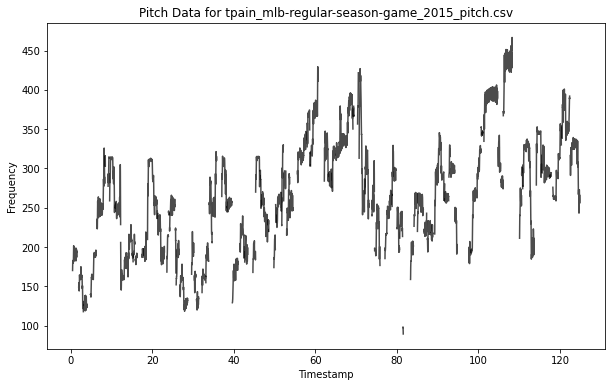

File 53: Flag file tpain_mlb-regular-season-game_2015_pitch.csv? (y/n): n


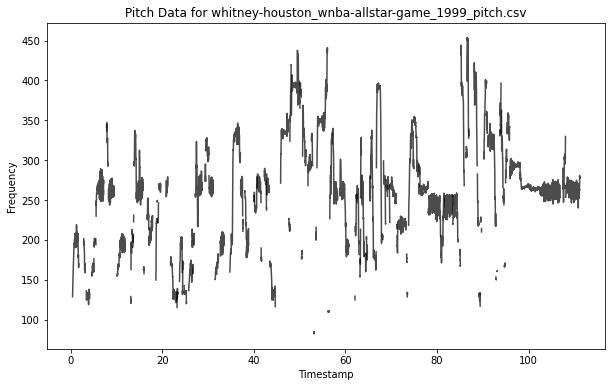

File 54: Flag file whitney-houston_wnba-allstar-game_1999_pitch.csv? (y/n): n


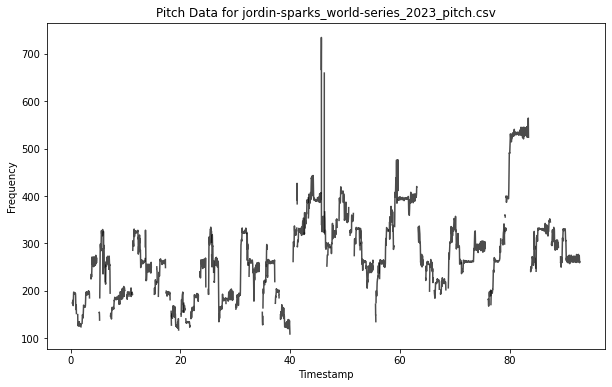

File 55: Flag file jordin-sparks_world-series_2023_pitch.csv? (y/n): y


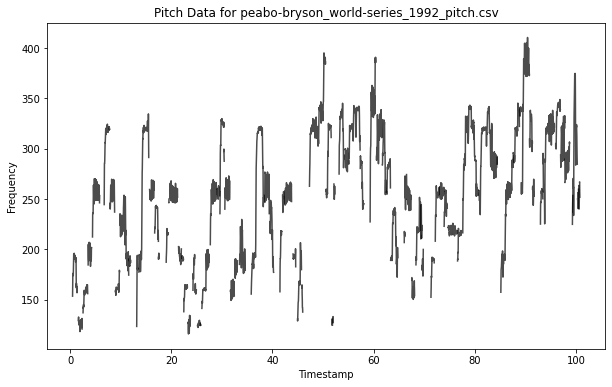

File 56: Flag file peabo-bryson_world-series_1992_pitch.csv? (y/n): n


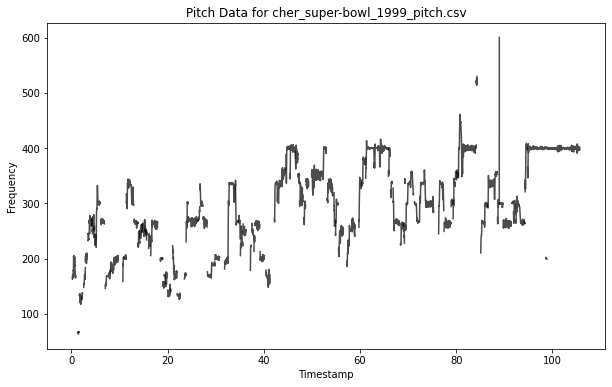

File 57: Flag file cher_super-bowl_1999_pitch.csv? (y/n): y


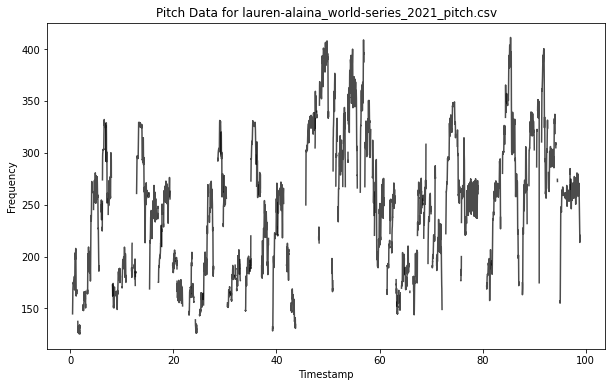

File 58: Flag file lauren-alaina_world-series_2021_pitch.csv? (y/n): n


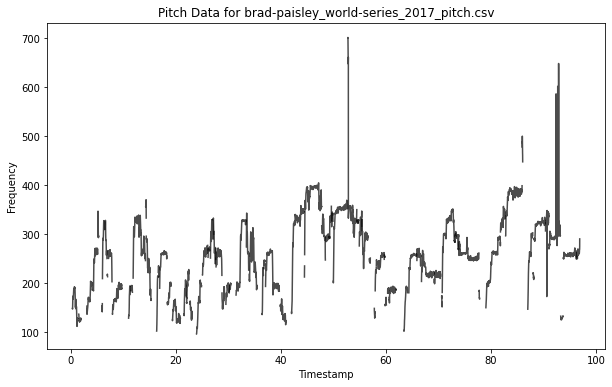

File 59: Flag file brad-paisley_world-series_2017_pitch.csv? (y/n): y


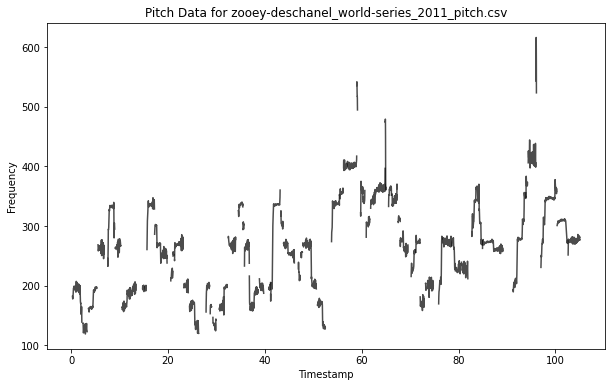

File 60: Flag file zooey-deschanel_world-series_2011_pitch.csv? (y/n): y


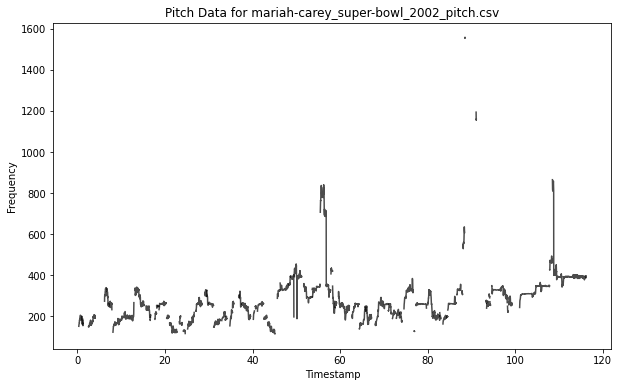

File 61: Flag file mariah-carey_super-bowl_2002_pitch.csv? (y/n): y


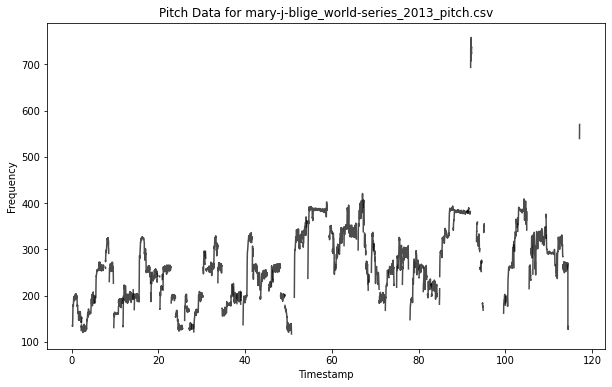

File 62: Flag file mary-j-blige_world-series_2013_pitch.csv? (y/n): y


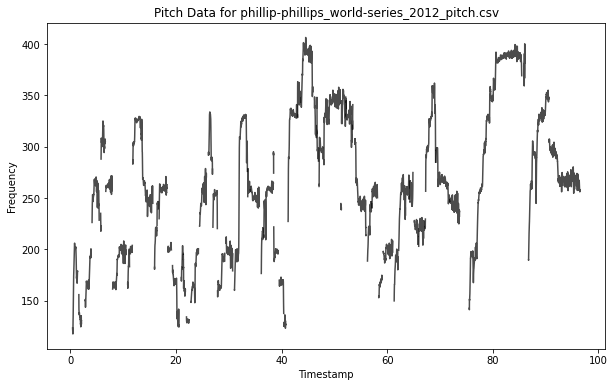

File 63: Flag file phillip-phillips_world-series_2012_pitch.csv? (y/n): n


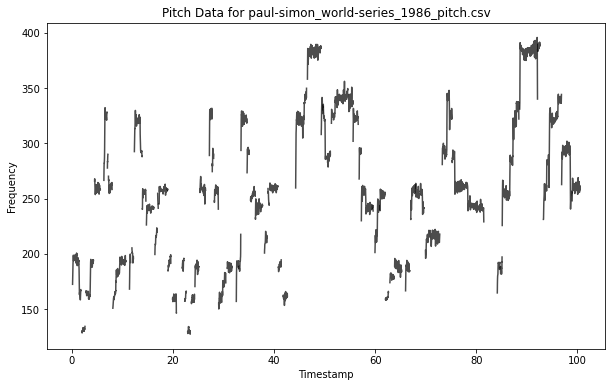

File 64: Flag file paul-simon_world-series_1986_pitch.csv? (y/n): n


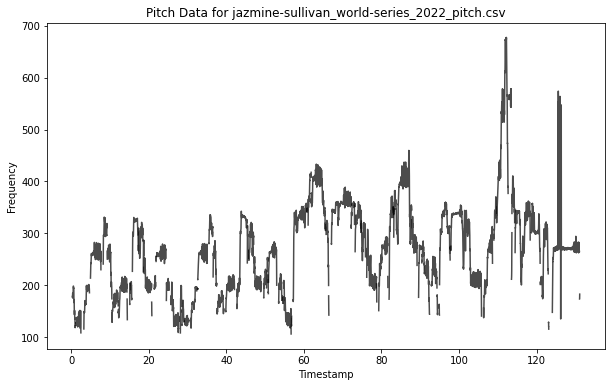

File 65: Flag file jazmine-sullivan_world-series_2022_pitch.csv? (y/n): n


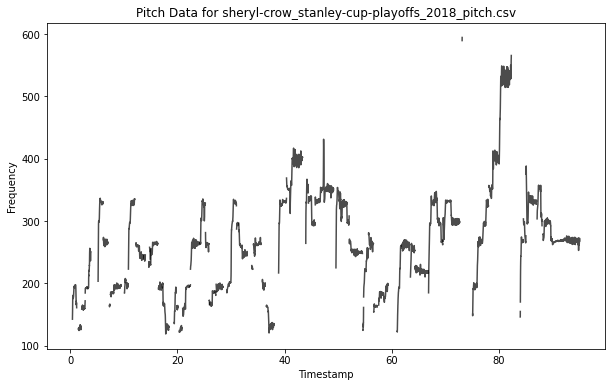

File 66: Flag file sheryl-crow_stanley-cup-playoffs_2018_pitch.csv? (y/n): y


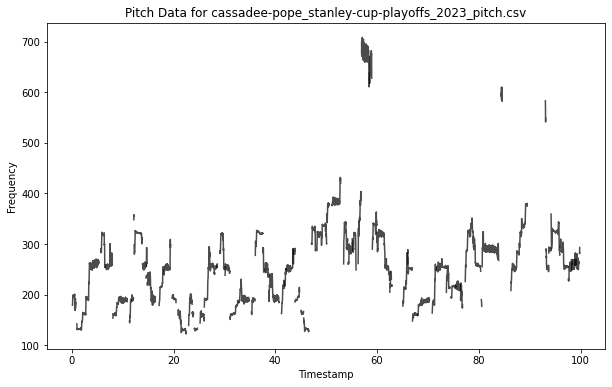

File 67: Flag file cassadee-pope_stanley-cup-playoffs_2023_pitch.csv? (y/n): y


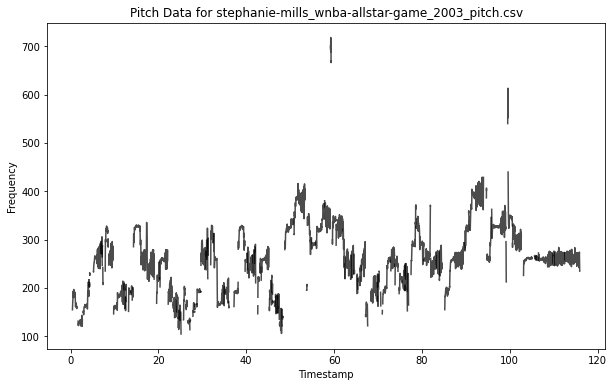

File 68: Flag file stephanie-mills_wnba-allstar-game_2003_pitch.csv? (y/n): y


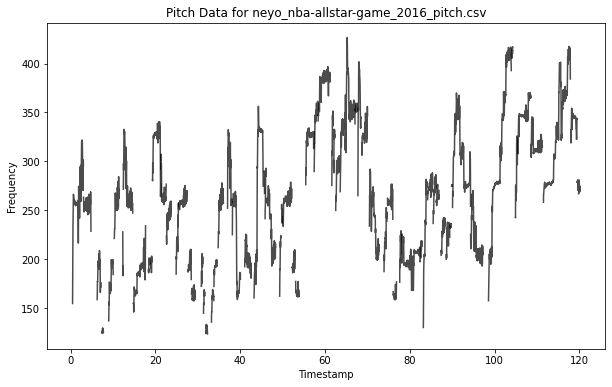

File 69: Flag file neyo_nba-allstar-game_2016_pitch.csv? (y/n): n


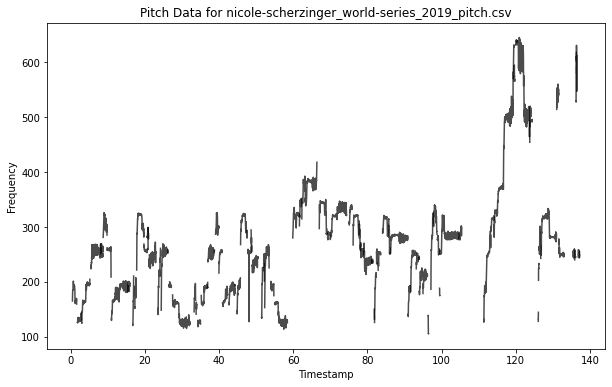

File 70: Flag file nicole-scherzinger_world-series_2019_pitch.csv? (y/n): y


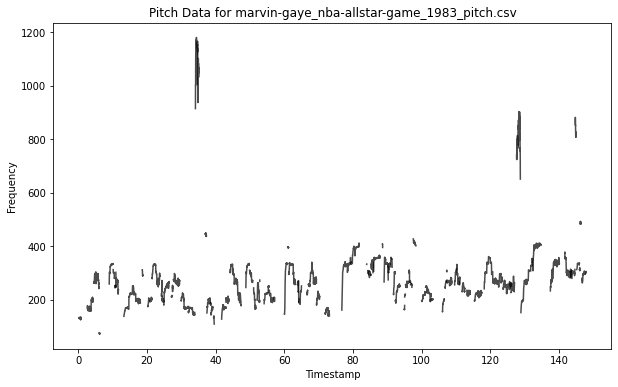

File 71: Flag file marvin-gaye_nba-allstar-game_1983_pitch.csv? (y/n): y


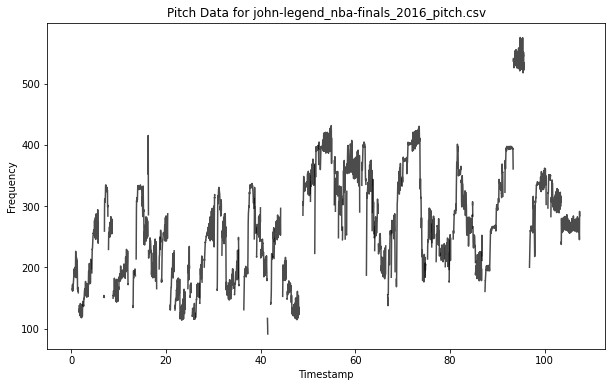

File 72: Flag file john-legend_nba-finals_2016_pitch.csv? (y/n): y


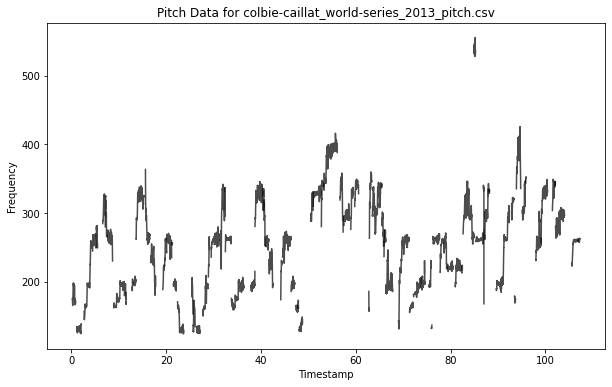

File 73: Flag file colbie-caillat_world-series_2013_pitch.csv? (y/n): y


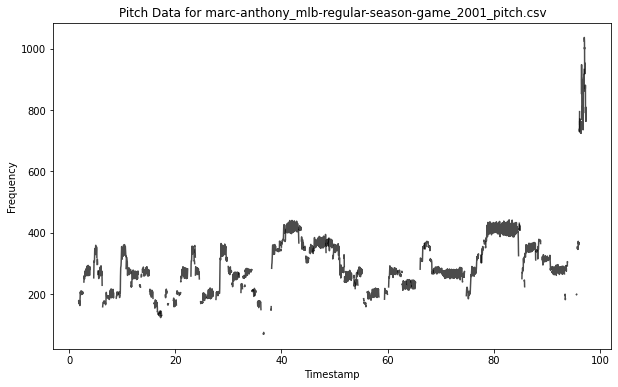

File 74: Flag file marc-anthony_mlb-regular-season-game_2001_pitch.csv? (y/n): y


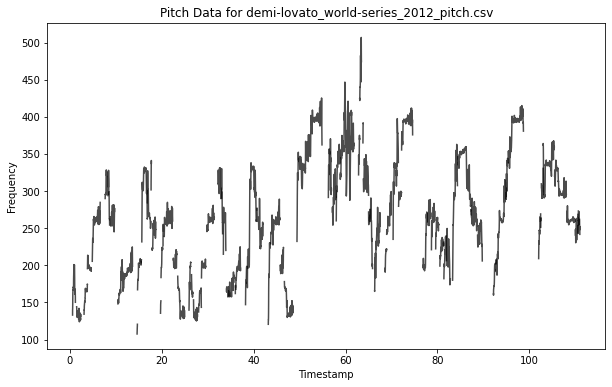

File 75: Flag file demi-lovato_world-series_2012_pitch.csv? (y/n): n


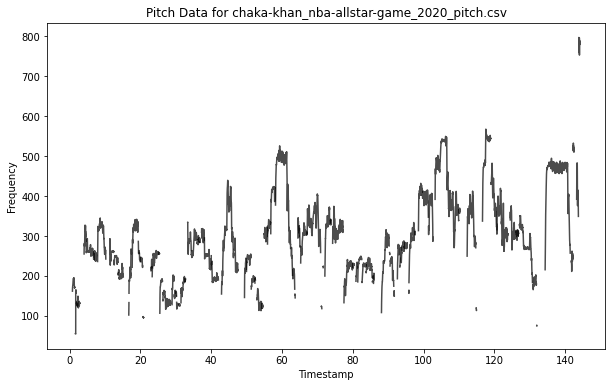

File 76: Flag file chaka-khan_nba-allstar-game_2020_pitch.csv? (y/n): y


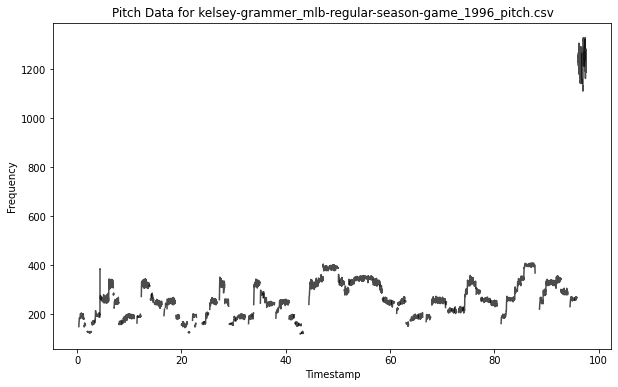

File 77: Flag file kelsey-grammer_mlb-regular-season-game_1996_pitch.csv? (y/n): y


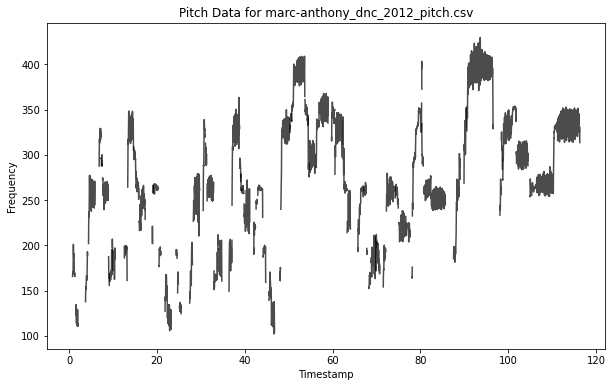

File 78: Flag file marc-anthony_dnc_2012_pitch.csv? (y/n): n


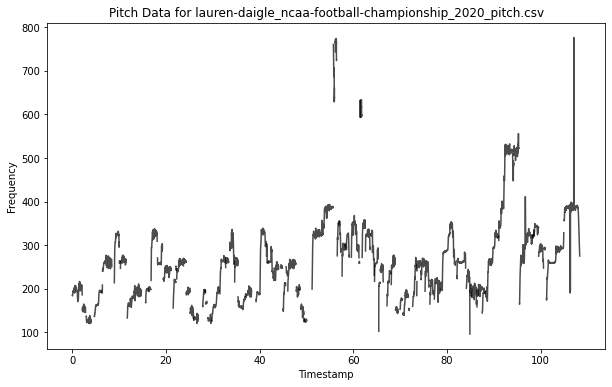

File 79: Flag file lauren-daigle_ncaa-football-championship_2020_pitch.csv? (y/n): y


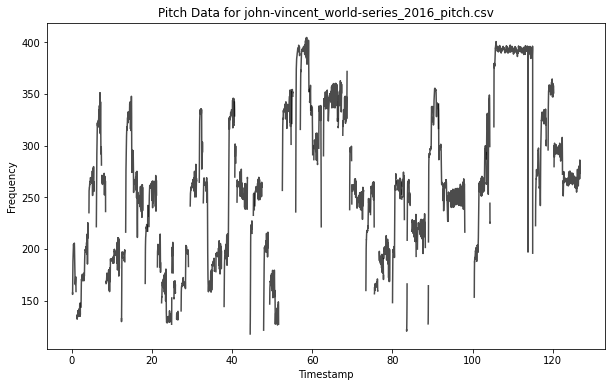

File 80: Flag file john-vincent_world-series_2016_pitch.csv? (y/n): n


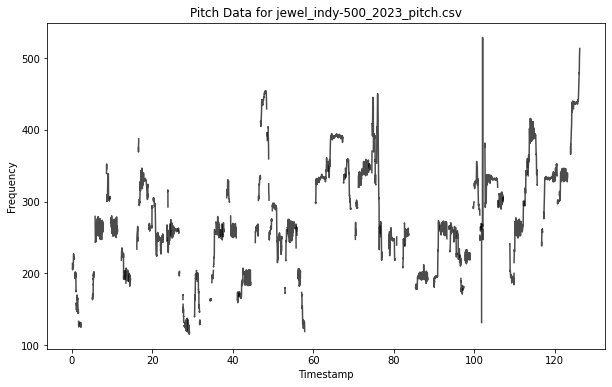

File 81: Flag file jewel_indy-500_2023_pitch.csv? (y/n): y


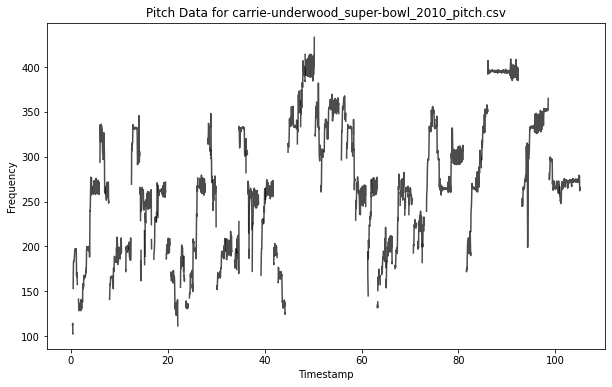

File 82: Flag file carrie-underwood_super-bowl_2010_pitch.csv? (y/n): n


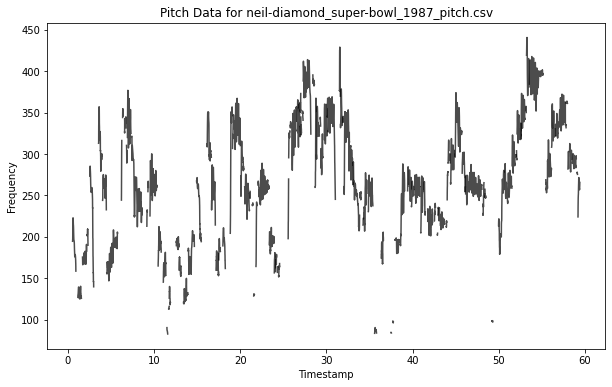

File 83: Flag file neil-diamond_super-bowl_1987_pitch.csv? (y/n): y


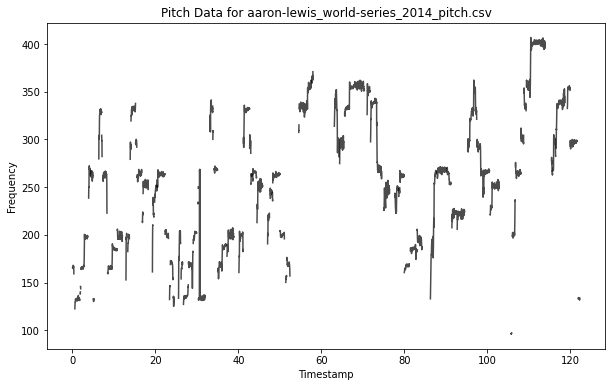

File 84: Flag file aaron-lewis_world-series_2014_pitch.csv? (y/n): n


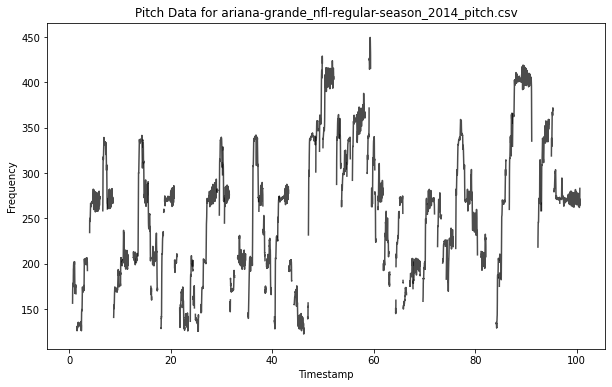

File 85: Flag file ariana-grande_nfl-regular-season_2014_pitch.csv? (y/n): n


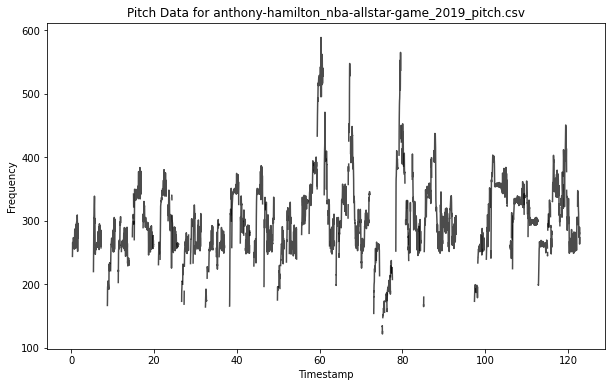

File 86: Flag file anthony-hamilton_nba-allstar-game_2019_pitch.csv? (y/n): n


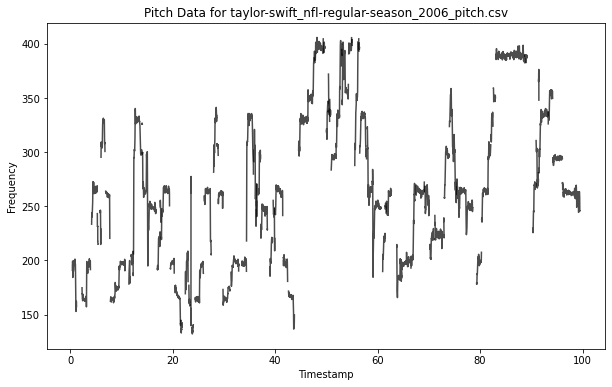

File 87: Flag file taylor-swift_nfl-regular-season_2006_pitch.csv? (y/n): n


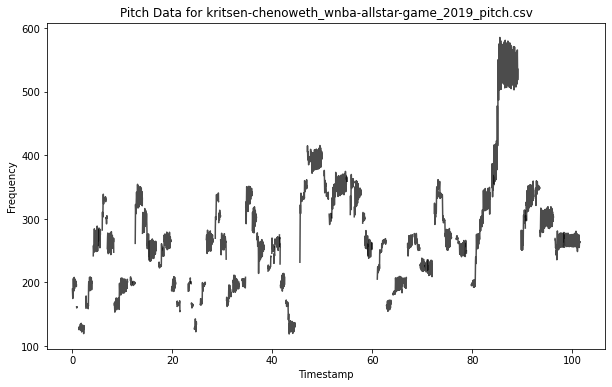

File 88: Flag file kritsen-chenoweth_wnba-allstar-game_2019_pitch.csv? (y/n): n


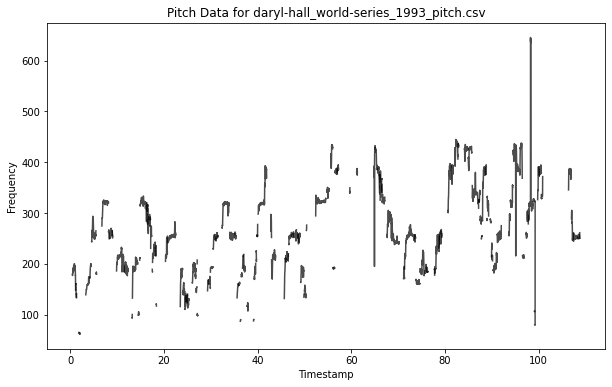

File 89: Flag file daryl-hall_world-series_1993_pitch.csv? (y/n): y


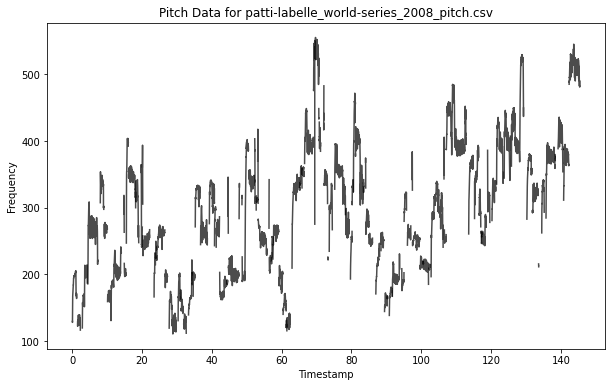

File 90: Flag file patti-labelle_world-series_2008_pitch.csv? (y/n): n


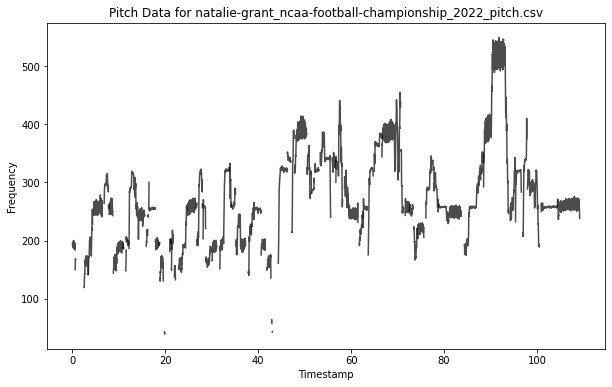

File 91: Flag file natalie-grant_ncaa-football-championship_2022_pitch.csv? (y/n): n


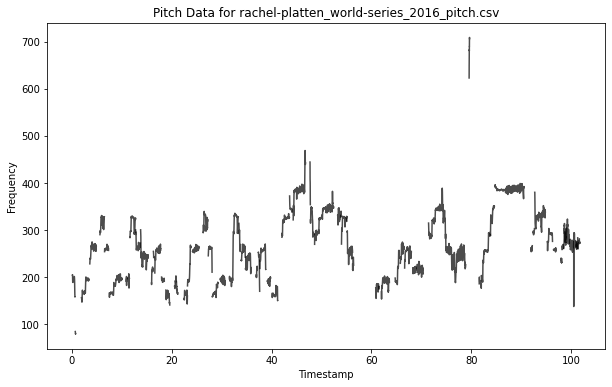

File 92: Flag file rachel-platten_world-series_2016_pitch.csv? (y/n): y


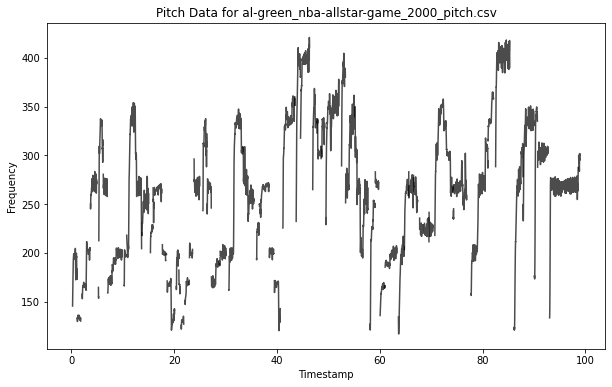

File 93: Flag file al-green_nba-allstar-game_2000_pitch.csv? (y/n): n


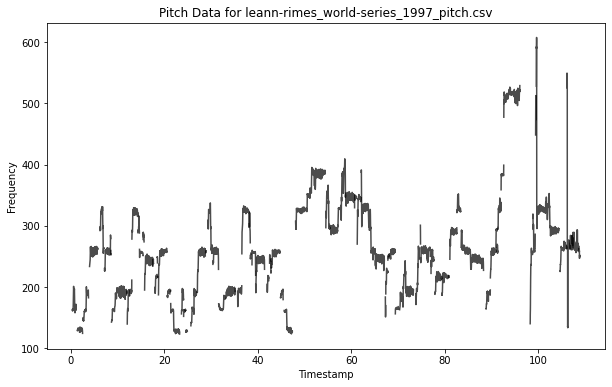

File 94: Flag file leann-rimes_world-series_1997_pitch.csv? (y/n): y


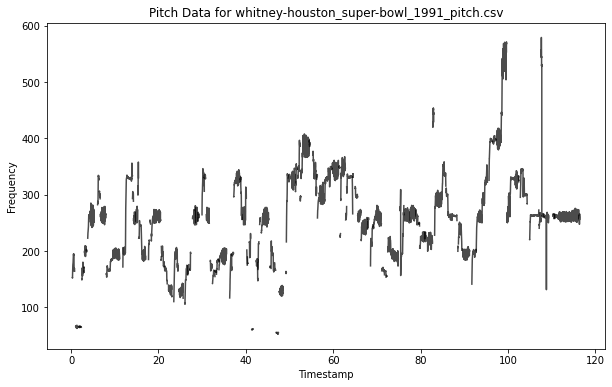

File 95: Flag file whitney-houston_super-bowl_1991_pitch.csv? (y/n): y


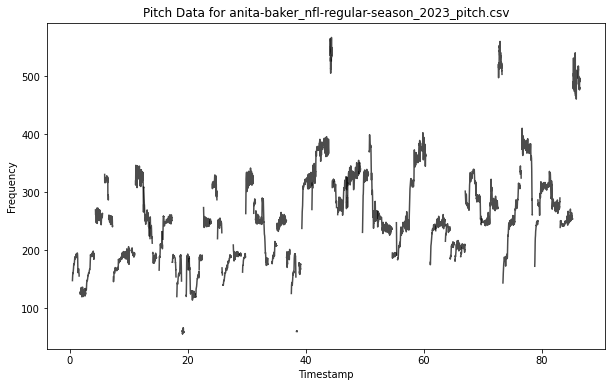

File 96: Flag file anita-baker_nfl-regular-season_2023_pitch.csv? (y/n): y


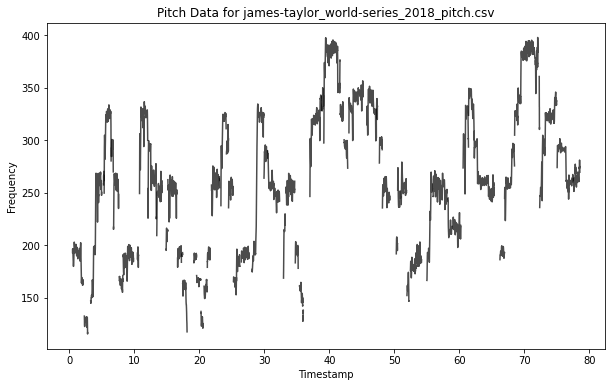

File 97: Flag file james-taylor_world-series_2018_pitch.csv? (y/n): n


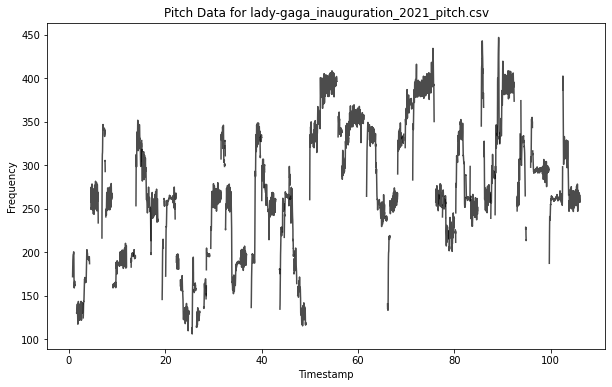

File 98: Flag file lady-gaga_inauguration_2021_pitch.csv? (y/n): n


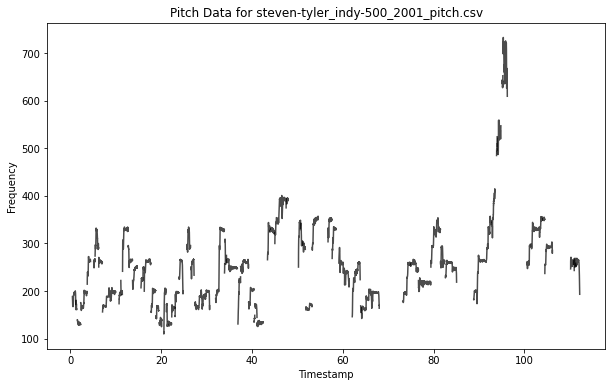

File 99: Flag file steven-tyler_indy-500_2001_pitch.csv? (y/n): y


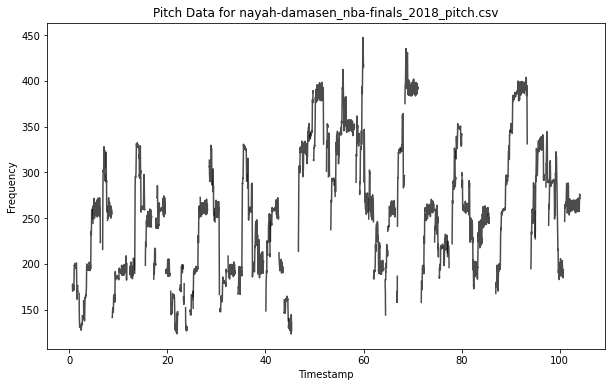

File 100: Flag file nayah-damasen_nba-finals_2018_pitch.csv? (y/n): n


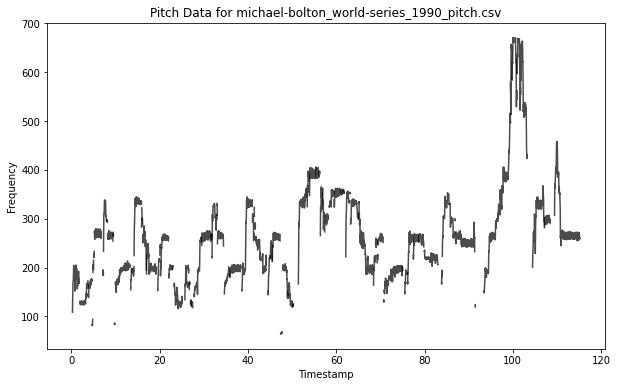

File 101: Flag file michael-bolton_world-series_1990_pitch.csv? (y/n): y


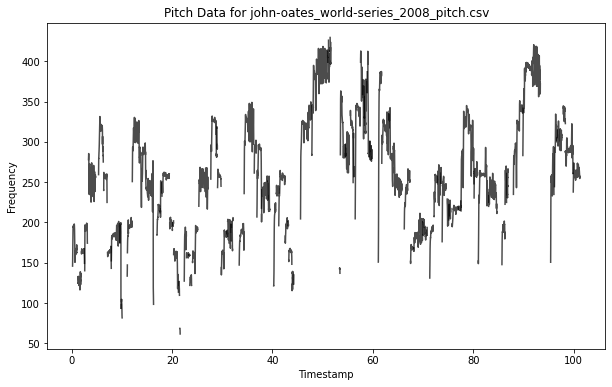

File 102: Flag file john-oates_world-series_2008_pitch.csv? (y/n): y


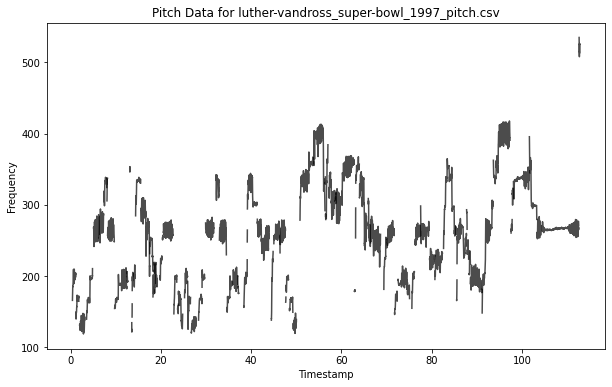

File 103: Flag file luther-vandross_super-bowl_1997_pitch.csv? (y/n): y


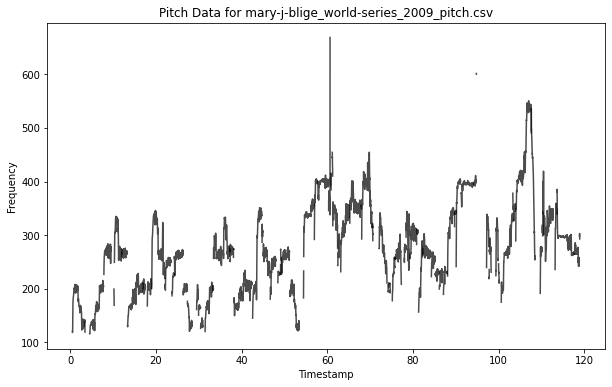

File 104: Flag file mary-j-blige_world-series_2009_pitch.csv? (y/n): y


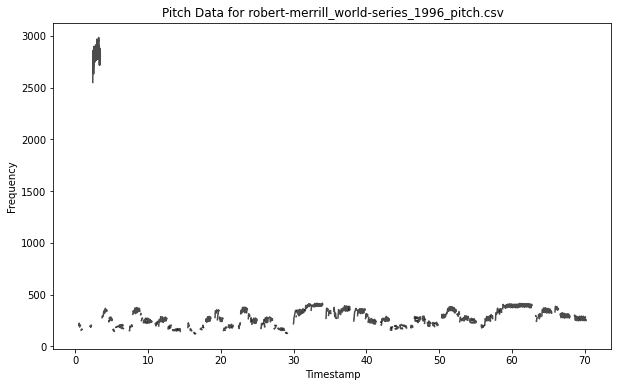

File 105: Flag file robert-merrill_world-series_1996_pitch.csv? (y/n): y


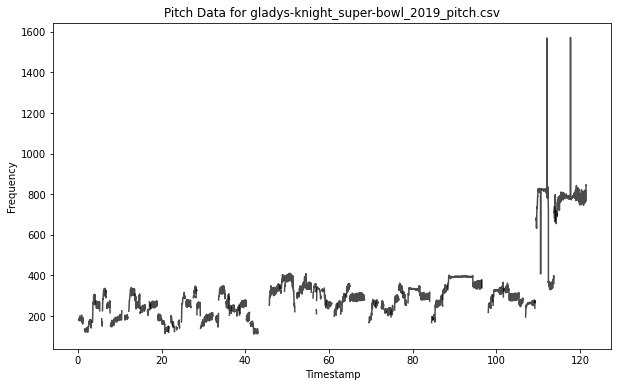

File 106: Flag file gladys-knight_super-bowl_2019_pitch.csv? (y/n): y


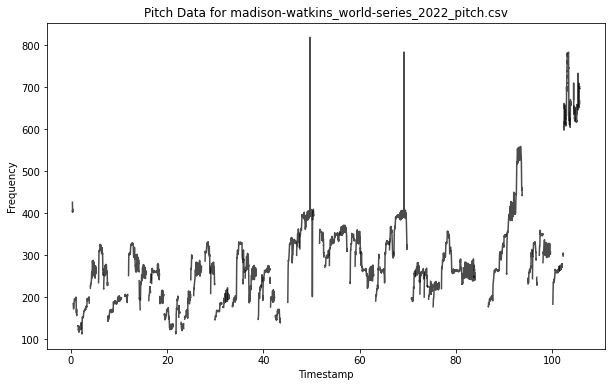

File 107: Flag file madison-watkins_world-series_2022_pitch.csv? (y/n): y


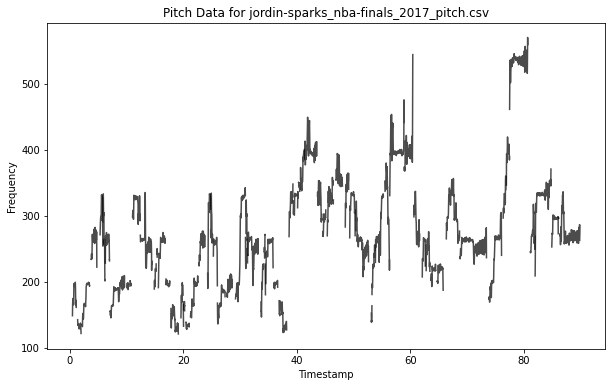

File 108: Flag file jordin-sparks_nba-finals_2017_pitch.csv? (y/n): n


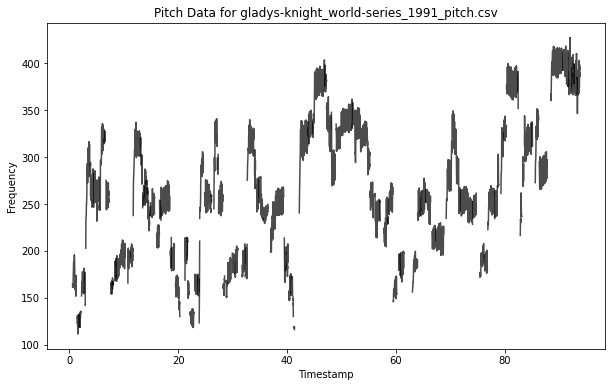

File 109: Flag file gladys-knight_world-series_1991_pitch.csv? (y/n): n


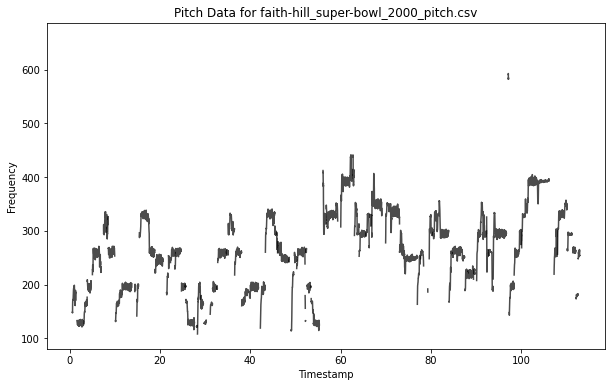

File 110: Flag file faith-hill_super-bowl_2000_pitch.csv? (y/n): y


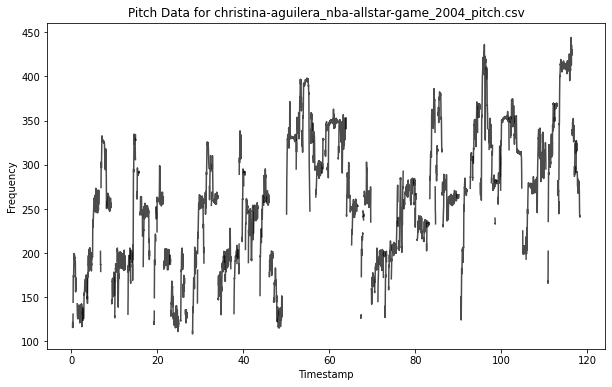

File 111: Flag file christina-aguilera_nba-allstar-game_2004_pitch.csv? (y/n): n


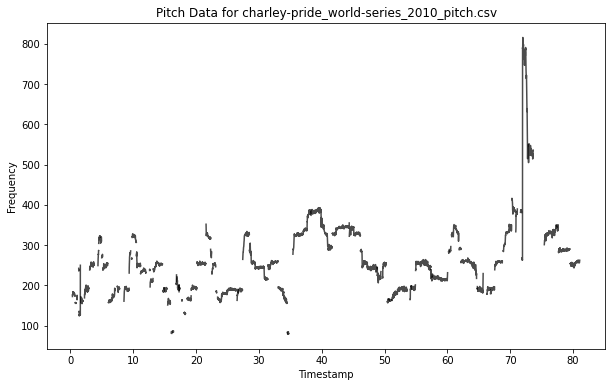

File 112: Flag file charley-pride_world-series_2010_pitch.csv? (y/n): y


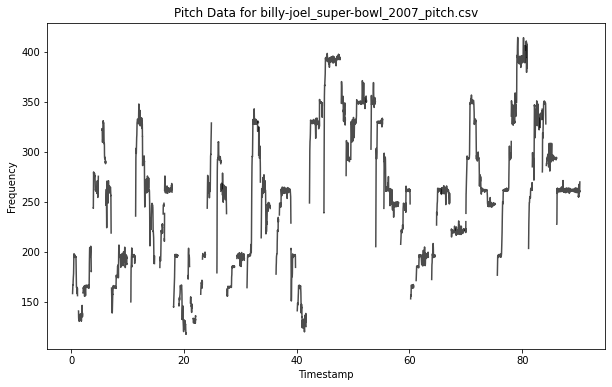

File 113: Flag file billy-joel_super-bowl_2007_pitch.csv? (y/n): n


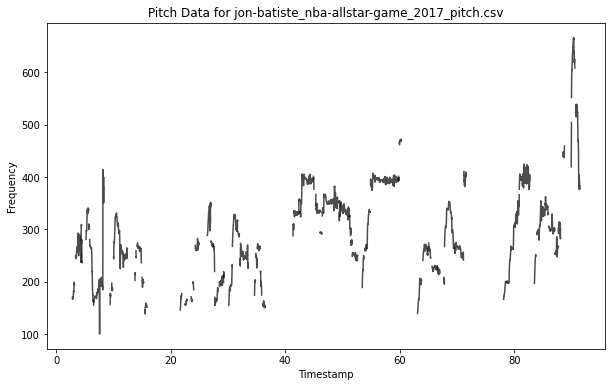

File 114: Flag file jon-batiste_nba-allstar-game_2017_pitch.csv? (y/n): n


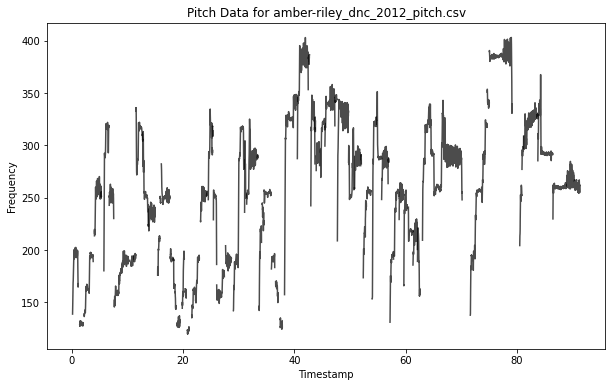

File 115: Flag file amber-riley_dnc_2012_pitch.csv? (y/n): y


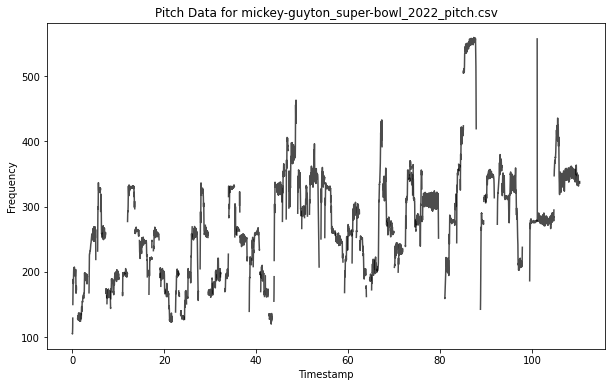

File 116: Flag file mickey-guyton_super-bowl_2022_pitch.csv? (y/n): n


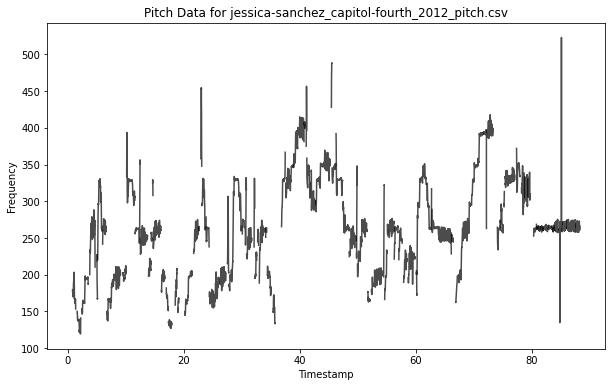

File 117: Flag file jessica-sanchez_capitol-fourth_2012_pitch.csv? (y/n): y


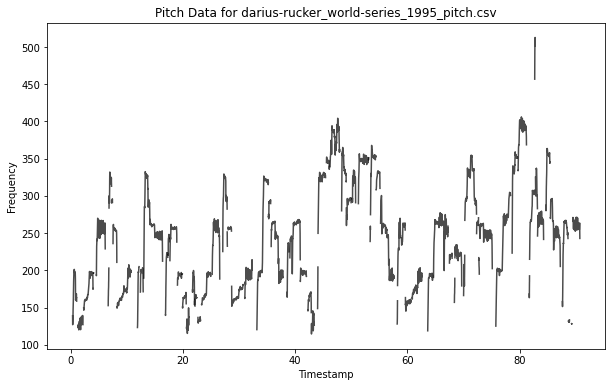

File 118: Flag file darius-rucker_world-series_1995_pitch.csv? (y/n): y


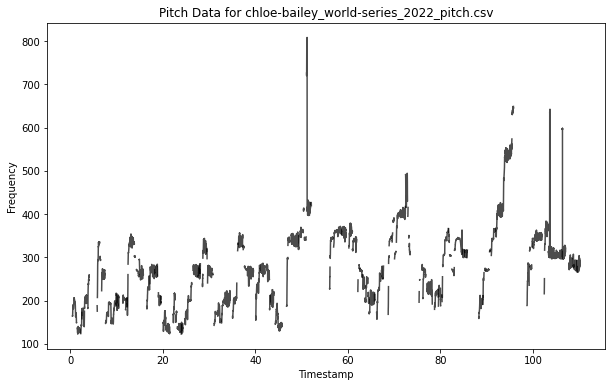

File 119: Flag file chloe-bailey_world-series_2022_pitch.csv? (y/n): y


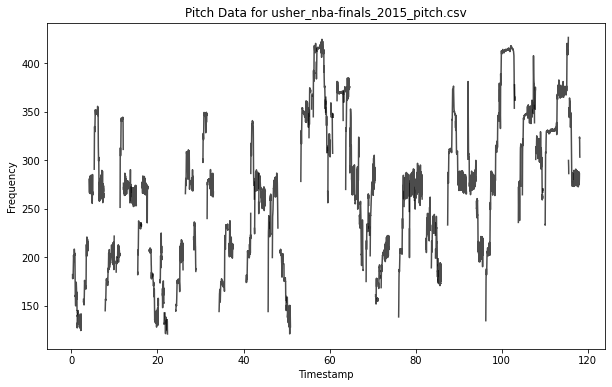

File 120: Flag file usher_nba-finals_2015_pitch.csv? (y/n): n


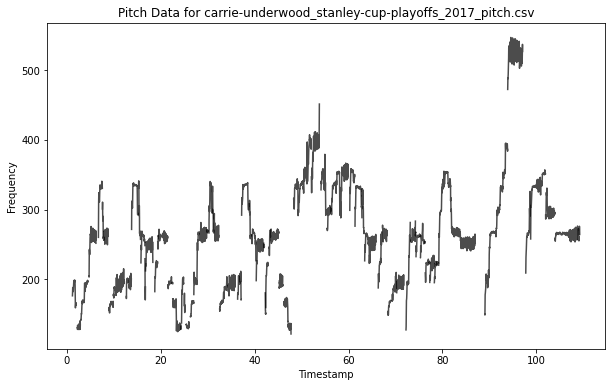

File 121: Flag file carrie-underwood_stanley-cup-playoffs_2017_pitch.csv? (y/n): y


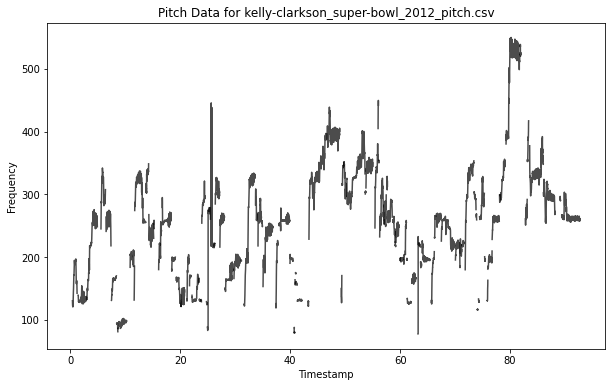

File 122: Flag file kelly-clarkson_super-bowl_2012_pitch.csv? (y/n): y


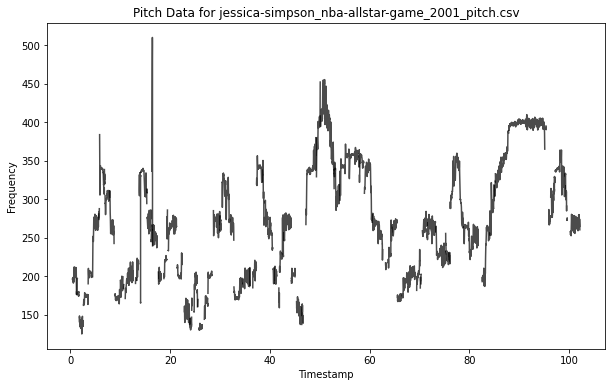

File 123: Flag file jessica-simpson_nba-allstar-game_2001_pitch.csv? (y/n): y


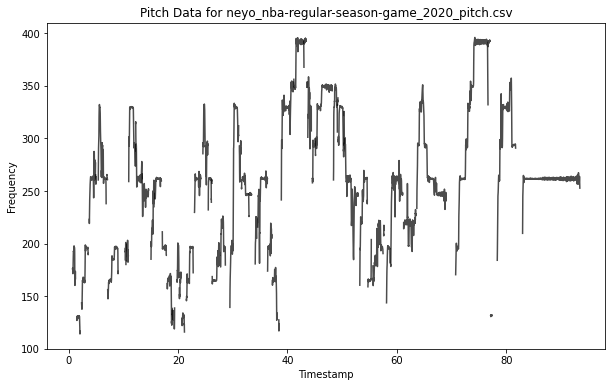

File 124: Flag file neyo_nba-regular-season-game_2020_pitch.csv? (y/n): y


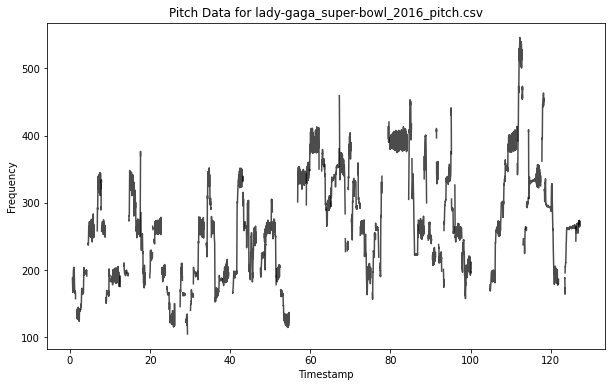

File 125: Flag file lady-gaga_super-bowl_2016_pitch.csv? (y/n): n


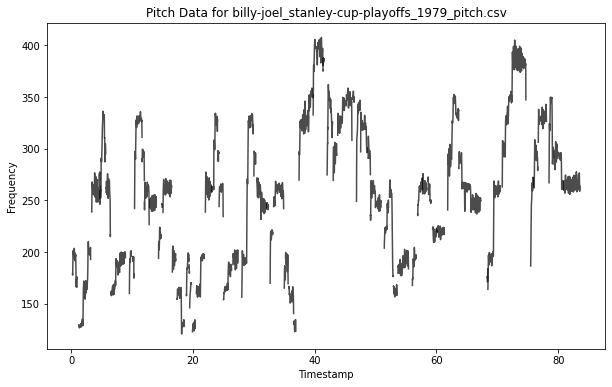

File 126: Flag file billy-joel_stanley-cup-playoffs_1979_pitch.csv? (y/n): n


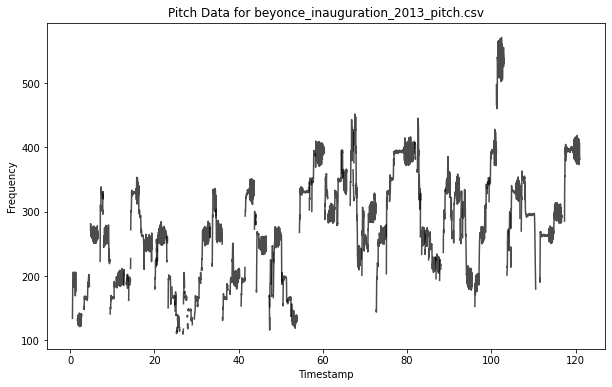

File 127: Flag file beyonce_inauguration_2013_pitch.csv? (y/n): n


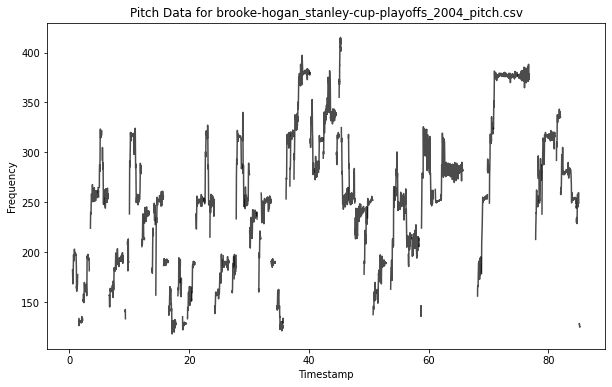

File 128: Flag file brooke-hogan_stanley-cup-playoffs_2004_pitch.csv? (y/n): y


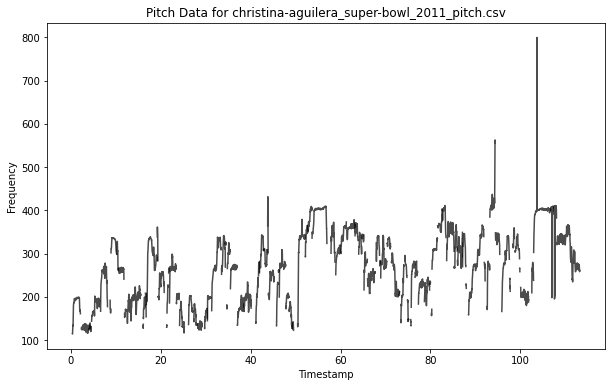

File 129: Flag file christina-aguilera_super-bowl_2011_pitch.csv? (y/n): n


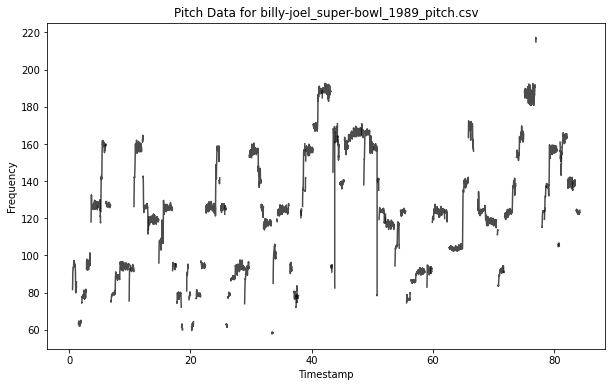

File 130: Flag file billy-joel_super-bowl_1989_pitch.csv? (y/n): y


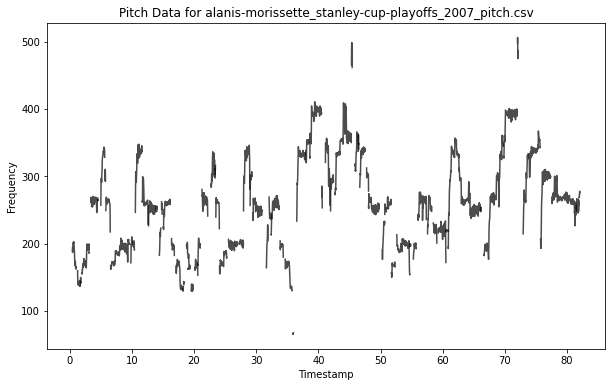

File 131: Flag file alanis-morissette_stanley-cup-playoffs_2007_pitch.csv? (y/n): y


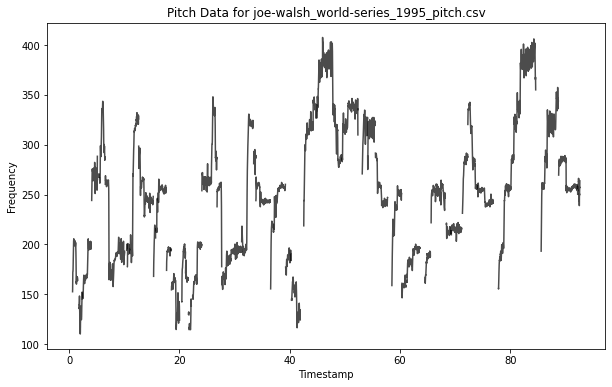

File 132: Flag file joe-walsh_world-series_1995_pitch.csv? (y/n): n


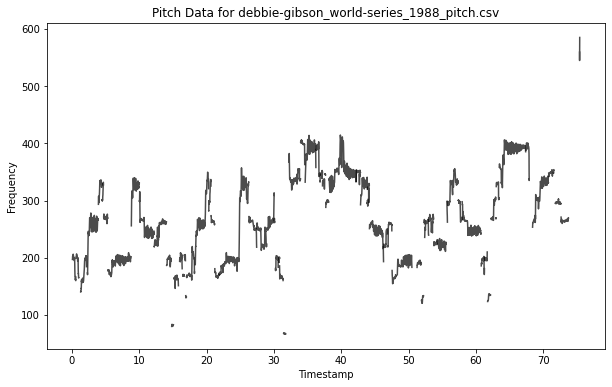

File 133: Flag file debbie-gibson_world-series_1988_pitch.csv? (y/n): y


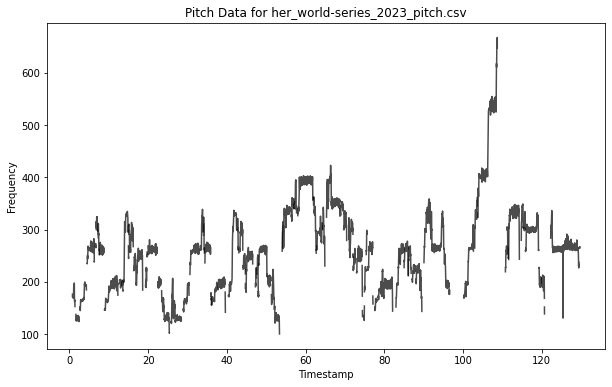

File 134: Flag file her_world-series_2023_pitch.csv? (y/n): n


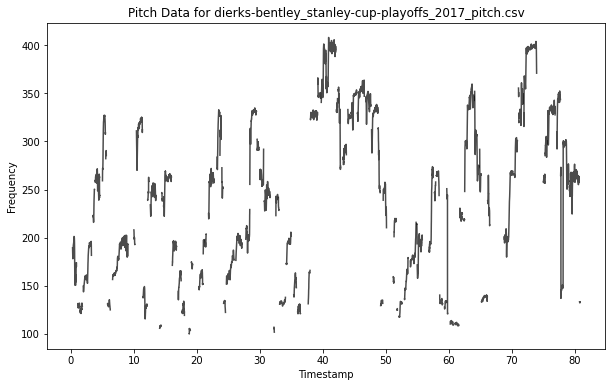

File 135: Flag file dierks-bentley_stanley-cup-playoffs_2017_pitch.csv? (y/n): y


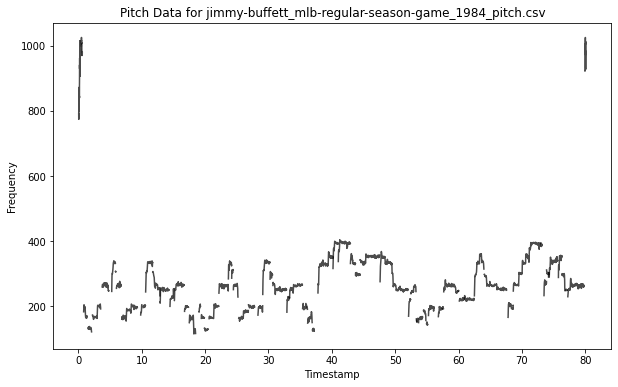

File 136: Flag file jimmy-buffett_mlb-regular-season-game_1984_pitch.csv? (y/n): y


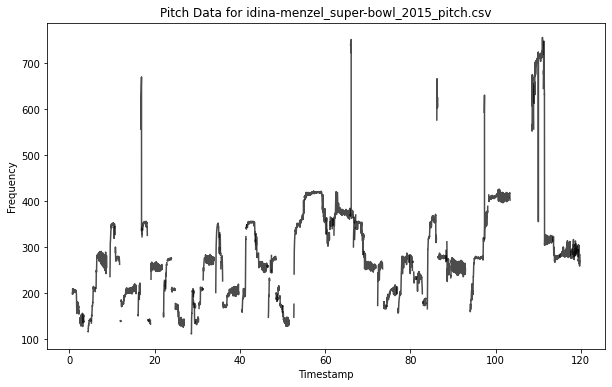

File 137: Flag file idina-menzel_super-bowl_2015_pitch.csv? (y/n): y


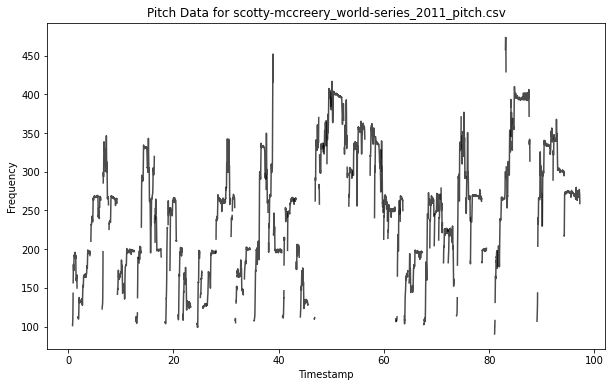

File 138: Flag file scotty-mccreery_world-series_2011_pitch.csv? (y/n): y


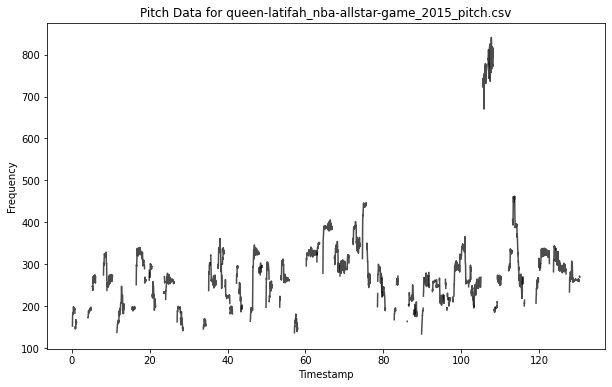

File 139: Flag file queen-latifah_nba-allstar-game_2015_pitch.csv? (y/n): y


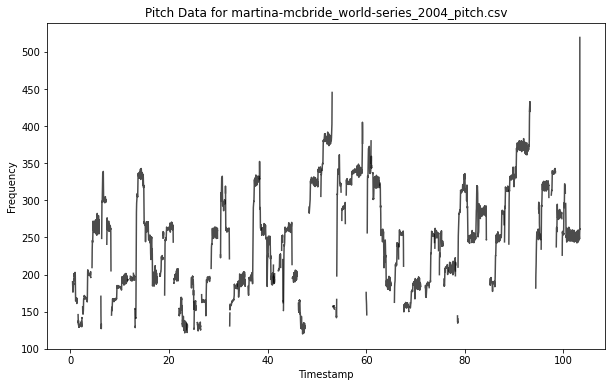

File 140: Flag file martina-mcbride_world-series_2004_pitch.csv? (y/n): y


In [3]:
def manual_flag():
    flagged_data = []
    directory = 'pitch-transposed'  # Directory containing the files
    file_count = 0  # Counter for the file number

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_count += 1
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)

            # Process the data to create disconnected segments
            # Group the data by consecutive non-zero frequency values
            data['group'] = (data['frequency'] == 0).cumsum()
            grouped = data[data['frequency'] != 0].groupby('group')

            # Plotting the data with disconnected segments
            plt.figure(figsize=(10, 6))
            for _, segment in grouped:
                plt.plot(segment['timestamp'], segment['frequency'], color='black', alpha=0.7)

            plt.xlabel('Timestamp')
            plt.ylabel('Frequency')
            plt.title(f'Pitch Data for {filename}')
            plt.show()

            # Prompting for flagging
            flag = input(f"File {file_count}: Flag file {filename}? (y/n): ").strip().lower()
            flagged_data.append({'id': filename, 'flagged': flag == 'y'})

    # Creating a DataFrame from the flagged data and saving it as a CSV
    flagged_df = pd.DataFrame(flagged_data)
    flagged_df.to_csv('flagged.csv', index=False)

manual_flag()

# 🎤 DIVA 

## D = Density

Total notes in the performance compared to the standard performance.

In [8]:
def density(id):
    standard = performances['michelle']
    standard_length = len(standard['words_data'])
    length = len(performances[id]['words_data'])
    return ((length - standard_length) / standard_length)*100

In [35]:
# The top n by density
n = 3
density_dict = {performer: density(performer) for performer, data in performances.items()}
sorted_density = sorted(density_dict.items(), key=lambda x: x[1], reverse=True)[:n]
for performer, density_value in sorted_density:
    print(f"{performer}: {density_value}")

jazmine: 97.84172661870504
demi: 58.992805755395686
carrie: 41.007194244604314


## I = Interpretation

Comparing the pitch curve to the standard curve using DTW.

In [29]:
standard_performance = np.array(performances['michelle']['pitch_data']['frequency'].tolist())
dtw_differences = {}

for name, performance in performances.items():
    print(name)
    if name != 'michelle':
        current_performance = np.array(performance['pitch_data']['frequency'].tolist())
        distance = dtw(standard_performance, current_performance)
        dtw_differences[name] = distance
print('done')

michelle
jazmine
demi
carrie
harry
done


In [36]:
# Print top n DTW distances in descending order
n = 3
top_5 = sorted(dtw_differences.items(), key=lambda x: x[1], reverse=True)[:n]
for name, distance in top_5:
    print(f"{name}: {distance}")

jazmine: 5321.627768189828
demi: 5001.383439416785
carrie: 2900.211028984833


## V = Vibrato

Measuring how much vibrato they use.

I think we might want to cut this one

[(89.776, 90.08), (89.776, 90.085333333), (89.776, 90.090666667), (89.776, 90.096), (89.776, 90.101333333), (89.776, 90.106666667), (89.776, 90.112), (89.776, 90.117333333), (89.776, 90.122666667), (89.776, 90.128), (89.776, 90.133333333), (89.776, 90.138666667), (89.776, 90.144), (89.776, 90.149333333), (89.776, 90.154666667), (89.776, 90.16), (89.776, 90.165333333), (89.776, 90.170666667), (89.776, 90.176), (89.776, 90.181333333), (89.776, 90.186666667), (89.776, 90.192), (89.776, 90.197333333), (89.776, 90.202666667)]
Vibrato score for michelle: 150


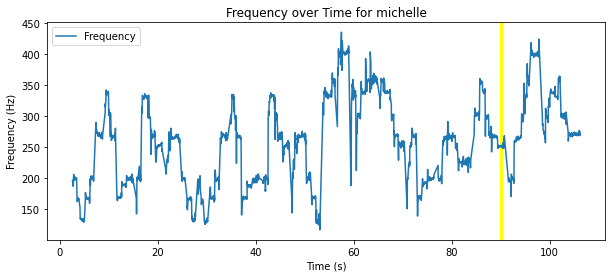

[(99.723900227, 100.025759637), (99.723900227, 100.031564626), (99.723900227, 100.037369615), (99.723900227, 100.043174603), (99.723900227, 100.048979592), (99.723900227, 100.05478458), (99.723900227, 100.060589569), (99.723900227, 100.066394558), (99.723900227, 100.072199546), (99.723900227, 100.078004535), (99.723900227, 100.083809524), (99.723900227, 100.089614512), (99.723900227, 100.095419501), (99.723900227, 100.10122449), (99.723900227, 100.107029478), (99.723900227, 100.112834467), (99.723900227, 100.118639456), (100.223129252, 100.524988662)]
Vibrato score for jazmine: 235


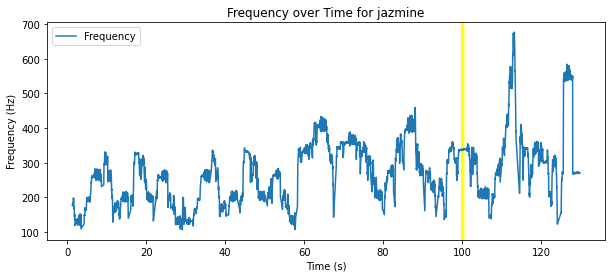

[]
Vibrato score for demi: 0


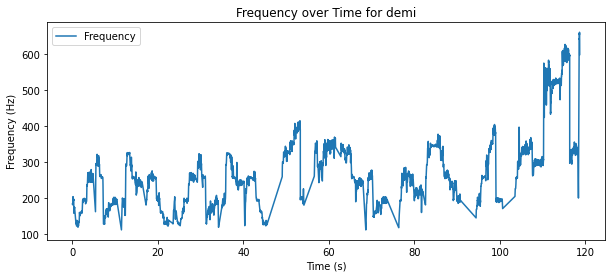

[(48.477460317, 48.779319728), (48.477460317, 48.785124717), (48.477460317, 48.790929705), (48.477460317, 48.796734694), (48.477460317, 48.802539683), (48.477460317, 48.808344671), (48.477460317, 48.81414966), (48.477460317, 48.819954649), (48.477460317, 48.825759637), (48.477460317, 48.831564626), (48.477460317, 48.837369615), (48.477460317, 48.843174603), (48.477460317, 48.848979592), (48.477460317, 48.85478458), (48.477460317, 48.860589569), (48.477460317, 48.866394558), (48.477460317, 48.872199546), (48.477460317, 48.878004535), (48.477460317, 48.883809524), (48.477460317, 48.889614512), (48.477460317, 48.895419501), (48.477460317, 48.90122449), (48.477460317, 48.907029478), (48.477460317, 48.912834467), (48.477460317, 48.918639456), (48.477460317, 48.924444444), (48.477460317, 48.930249433), (48.477460317, 48.936054422), (48.477460317, 48.94185941), (48.477460317, 48.947664399), (48.477460317, 48.953469388), (48.477460317, 48.959274376), (48.477460317, 48.965079365), (48.477460317

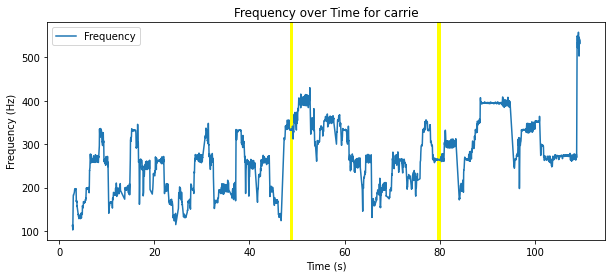

[(105.250249433, 105.552108844), (105.250249433, 105.557913832)]
Vibrato score for harry: 24


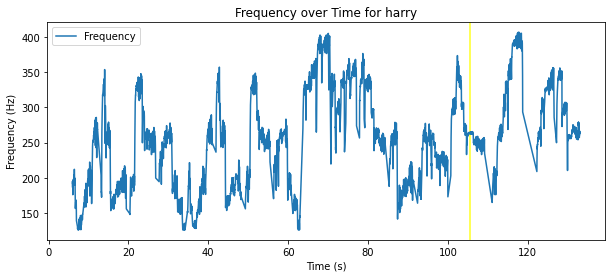

In [42]:
def detect_vibrato(pitch_data, min_duration=0.3, rate_threshold=5):
    """
    Detects vibrato in pitch data and returns the vibrato score and segments.

    :param pitch_data: DataFrame with 'timestamp' and 'frequency'.
    :param min_duration: Minimum duration (in seconds) to consider a note sustained.
    :param rate_threshold: Minimum rate of vibrato oscillations (in oscillations per second).
    :return: Vibrato score and list of vibrato segments (start and end times).
    """
    vibrato_score = 0
    vibrato_segments = []
    prev_freq = pitch_data['frequency'].iloc[0]
    start_time = pitch_data['timestamp'].iloc[0]

    for index, row in pitch_data.iterrows():
        freq_threshold = 0.07 * row['frequency']
        
        if abs(row['frequency'] - prev_freq) <= freq_threshold:
            duration = row['timestamp'] - start_time
            if duration >= min_duration:
                # Potential vibrato segment found
                segment = pitch_data[(pitch_data['timestamp'] >= start_time) & (pitch_data['timestamp'] <= row['timestamp'])]
                # Analyze for oscillation rate and depth
                oscillations = count_oscillations(segment, rate_threshold)
                vibrato_score += oscillations
                if oscillations > 0:
                    vibrato_segments.append((start_time, row['timestamp']))
        else:
            prev_freq = row['frequency']
            start_time = row['timestamp']

    return vibrato_score, vibrato_segments

def count_oscillations(segment, rate_threshold):
    frequencies = segment['frequency'].values
    timestamps = segment['timestamp'].values

    # Find peaks and troughs
    peaks = np.zeros(len(frequencies), dtype=bool)
    troughs = np.zeros(len(frequencies), dtype=bool)

    for i in range(1, len(frequencies) - 1):
        peaks[i] = frequencies[i] > frequencies[i - 1] and frequencies[i] > frequencies[i + 1]
        troughs[i] = frequencies[i] < frequencies[i - 1] and frequencies[i] < frequencies[i + 1]

    # Count cycles
    oscillation_count = 0
    in_cycle = False

    for i in range(1, len(frequencies) - 1):
        if (peaks[i] or troughs[i]) and not in_cycle:
            in_cycle = True
        elif in_cycle and (peaks[i] or troughs[i]):
            oscillation_count += 1
            in_cycle = False

    # Check rate of oscillations against the threshold
    duration = timestamps[-1] - timestamps[0]
    if duration > 0:
        rate = oscillation_count / duration
        if rate >= rate_threshold:
            return oscillation_count
    return 0


for name, performance in performances.items():
    vibrato_score, vibrato_segments = detect_vibrato(performance['pitch_data'])
    print(vibrato_segments)
    print(f"Vibrato score for {name}: {vibrato_score}")

    # Plotting the frequency over time
    plt.figure(figsize=(10, 4))
    plt.plot(performance['pitch_data']['timestamp'], performance['pitch_data']['frequency'], label='Frequency')
    
    # Highlight vibrato segments
    for start, end in vibrato_segments:
        plt.axvspan(start, end, color='yellow', alpha=0.3)

    plt.title(f"Frequency over Time for {name}")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

## A = Apex

What's their highest note?

In [45]:
highest_frequencies = {name: performance['pitch_data']['frequency'].max() for name, performance in performances.items()}
n = 3
sorted_performances = sorted(highest_frequencies.items(), key=lambda x: x[1], reverse=True)[:n]

for name, freq in sorted_performances:
    print(f"The highest frequency in {name}'s performance: {freq} Hz")


The highest frequency in jazmine's performance: 676.7403574128907 Hz
The highest frequency in demi's performance: 661.4207535633116 Hz
The highest frequency in carrie's performance: 558.1321103126033 Hz
